**Failure Forecasting Exercise**

**Problem Statement:**

The dataset provided is for a number of oil wells and their KPI's (key performance metrics). The wells provided have 2 conditions:
- Normal: Label = 0
- Failure: Label = 1

The client wants an algorithm which can forecast failures 5 days in advance.
  
**Data set Info**

The dataset is labeled and here's a quick overview of the data columns:

- `NodeID`: The well-name. The dataset containes samples from multiple oil wells and this column has the names of each well.
- `Date`: Timestamp. Datapoints are sampled with a frequency of `1 hour`
- `Label`: Binary labels of 0 and 1 where 1 indicates failure.
- The remaining columns represent data from various sensors.
    - MotorCurrent
    - Frequency
    - PIP
    - TubingPressure
    - CasingPressure
    - PIT
    - MotorTemperature
    - XVIB



In [ ]:
# intallation
!pip install s3fs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 72.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.3/269.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 2.6 MB/s eta 0:00:00


# Imports

In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import TimeSeriesSplit  # For time series cross validation
from sklearn.metrics import log_loss  # Cross entropy loss

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import plot_importance  # Feature importance
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # For Feature scaling
from sklearn.metrics import recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV


In [ ]:
# Importing the dataset
data = pd.read_csv('s3://enfinite-public/sample_data/sample_esp.csv', parse_dates=['Date'])
print('Data Sample:')
display(data.sample(5))

print('\nTotal Wells in the Data:', *data.NodeID.unique(), sep='\n')

print(f'\nOverall label Distribution:\n0 - {data.Label.value_counts()[0]}\n1 - {data.Label.value_counts()[1]} ')

print("\n\nNAN Value distribution:\n" )
display(data.isnull().sum(axis=0))

Data Sample:


NodeID                Date  MotorCurrent  Frequency          PIP  \
13585  Well G 2019-10-20 19:00:00     39.416667  57.083333   925.000000   
14463  Well G 2019-11-26 09:00:00     36.750000  57.000000   925.000000   
19035  Well I 2020-03-01 19:00:00     35.575000  54.172500  1253.008333   
5765   Well C 2019-10-18 03:00:00     31.250000  50.416667   692.083333   
25754  Well L 2020-04-16 15:00:00     27.583333  61.750000  1165.500000   

       TubingPressure  CasingPressure         PIT  MotorTemperature  \
13585      118.166667      120.000000  252.000000        252.000000   
14463      209.250000        0.000000  257.000000        258.000000   
19035      227.416667      122.750000  242.333333        282.583333   
5765       232.791667      157.333333  245.000000        281.666667   
25754      219.750000      201.250000  251.333333        284.666667   

             XVib  Label  
13585    1.000000      0  
14463    1.000000      1  
19035    1.916667      0  
5765   119.500000      0  
25754  107.166667      0


Total Wells in the Data:
Well A
Well B
Well C
Well D
Well E
Well F
Well G
Well H
Well I
Well J
Well K
Well L

Overall label Distribution:
0 - 24192
1 - 2028 


NAN Value distribution:



NodeID                0
Date                  0
MotorCurrent        595
Frequency           595
PIP                 595
TubingPressure      595
CasingPressure      595
PIT                 595
MotorTemperature    595
XVib                595
Label                 0
dtype: int64

# Usefull Functions

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [ ]:
def train_test_split(df, test_size=0.2):
  '''
  Function to split data into test and train
  '''
  split_index = int(len(df) * (1 - test_size))
  train_df = df.iloc[:split_index]
  test_df = df.iloc[split_index:]
  return train_df, test_df


In [ ]:
def print_nan_vals(data):
  """
  Print Nan values in a dataframe
  """
  print("\n\nNAN Value distribution:\n" )
  print(data.isnull().sum(axis=0))
  count = data.isnull().any(axis=1).sum()
  print(f'\nThe DataFrame contains {count} rows with at least one NaN value.\n')

  print(f"Total missing value rows = {count} / {data.shape[0]}")




In [ ]:
def linear_interpolate(data):
  '''
  Function to interpolate linearly for the time series dataset
  '''
  #columns = ['MotorCurrent','Frequency',	'PIP',	'TubingPressure',	'CasingPressure','PIT',	'MotorTemperature',	'XVib','Label',	'hour'	,'dayofweek',	'month',	'year'	,'dayofyear'	,'dayofmonth']
  data = data.interpolate(method='linear',limit_direction ='forward')
  return data



In [ ]:
# Function to transform data for ML

def df_to_X_y1(df, window_size=6, horizon=5):
    '''
    Windowing function and setting up the forcasting horizon
    '''
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size-horizon):
        row = [r for r in df_as_np[i:i+window_size].flatten()]
        X.append(row)
        label = df_as_np[i+window_size+horizon][8]
        y.append(label)
    return np.array(X), np.array(y)



In [ ]:
# Function to transform data for Deep Learning

def df_to_X_y2(df, window_size=6, horizon=5):
    '''
    Windowing function and setting up the forcasting horizon
    '''
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size-horizon):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size+horizon][8]
        y.append(label)
    return np.array(X), np.array(y)




In [ ]:
def plot_pred_vs_true(y_pred,y_test):
  '''
  Plotting function
  1.Calculate log loss
  2.Plot pred vs true
  3.Calculate recall
  4.Plot confusion matric
  '''

  # calculate log loss
  loss = log_loss(y_test, y_pred)
  print(f'\n Log loss : {loss:.4f} \n ')

  plt.figure(figsize=(10,5))
  plt.plot( y_pred, label='Predictions')
  plt.plot(y_test, label='True Values')
  plt.legend()
  plt.show()
  recall = recall_score(y_test, y_pred)  # tp/(tp+fn)
  print(f"\n Recall: {recall} \n ")

  # Calculate and plot confusion matrix
  # Calculate and plot confusion matrix
  # Row - True Label
  # Col - Pred Lable

  cm = confusion_matrix(y_test, y_pred)
  sns.heatmap(cm, annot=True)
  plt.ylabel('True label')
  plt.xlabel('Pred label')
  plt.show()

# EDA

In [ ]:
well_counts = data.groupby('NodeID').size()
print(well_counts)

NodeID
Well A    2329
Well B    1993
Well C    1657
Well D    1609
Well E    2329
Well F    2329
Well G    2329
Well H    2329
Well I    2329
Well J    2329
Well K    2329
Well L    2329
dtype: int64


In [ ]:
label_counts = data.groupby(['NodeID', 'Label']).size()
print(label_counts)

NodeID  Label
Well A  0        2160
        1         169
Well B  0        1824
        1         169
Well C  0        1488
        1         169
Well D  0        1440
        1         169
Well E  0        2160
        1         169
Well F  0        2160
        1         169
Well G  0        2160
        1         169
Well H  0        2160
        1         169
Well I  0        2160
        1         169
Well J  0        2160
        1         169
Well K  0        2160
        1         169
Well L  0        2160
        1         169
dtype: int64


## Label count plot

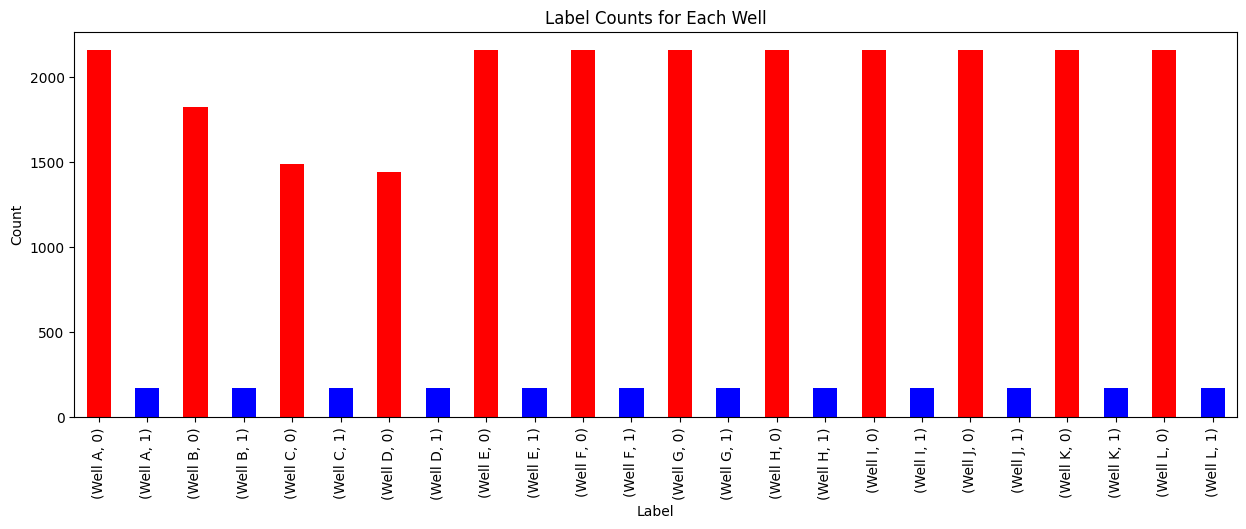

In [ ]:
label_counts.plot(kind='bar', color=['red', 'blue'],figsize=(15,5))

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts for Each Well')

plt.show()

## Data distribution plot

In [ ]:
data.describe()

MotorCurrent     Frequency           PIP  TubingPressure  \
count  25625.000000  25625.000000  25625.000000    25625.000000   
mean      29.001035     54.362822    835.531786      203.872787   
std        8.436798     12.846042    307.271353       64.228736   
min        0.000000      0.000000      0.000000        0.000000   
25%       25.650000     53.716667    567.428571      160.916667   
50%       30.750000     57.833333    859.000000      217.136364   
75%       33.545455     60.000000    999.000000      244.727273   
max       45.000000     64.083333   1845.250000      493.250000   

       CasingPressure           PIT  MotorTemperature          XVib  \
count    25625.000000  25625.000000      25625.000000  25625.000000   
mean       218.355574    242.890239        270.984579     59.822666   
std        409.166812     26.525505         30.894704     73.982932   
min          0.000000      0.000000          0.000000      0.000000   
25%        104.666667    235.000000        261.250000      2.000000   
50%        127.083333    245.000000        273.500000      6.250000   
75%        185.000000    252.000000        285.833333    109.083333   
max       3000.000000    308.416667        332.833333    430.000000   

              Label  
count  26220.000000  
mean       0.077346  
std        0.267144  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [ ]:
# Plotting the histogram of  values for each well with 50 bins
columns = ['Frequency',	'PIP',	'TubingPressure',	'CasingPressure','PIT',	'MotorTemperature',	'XVib']
for column in columns:
  fig = px.histogram(data, x=column, color='NodeID', nbins=50)

  fig.update_layout(
      title=f'Histogram of {column} Values for Different Wells',
      xaxis_title=column,
      yaxis_title='Count',
      legend_title='Well'
  )
  fig.show()

## Scatter plot

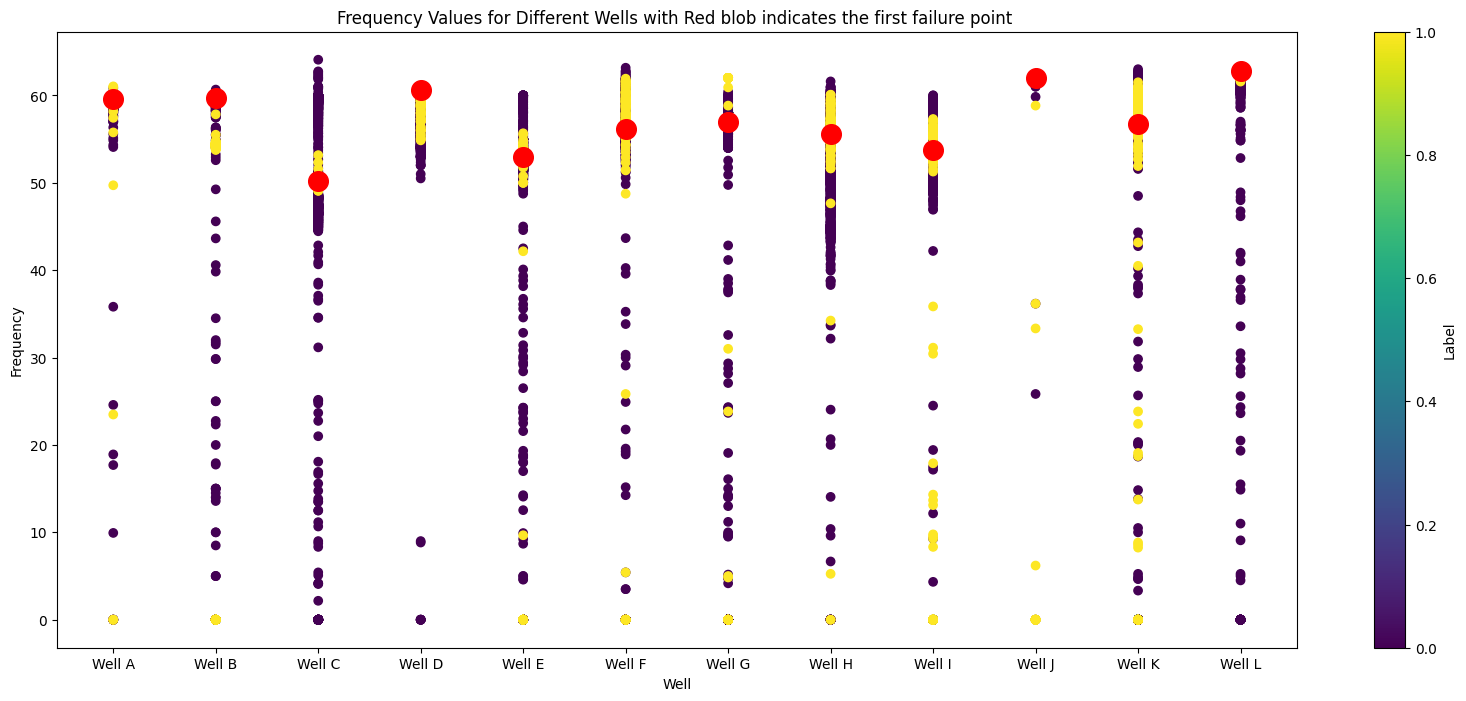

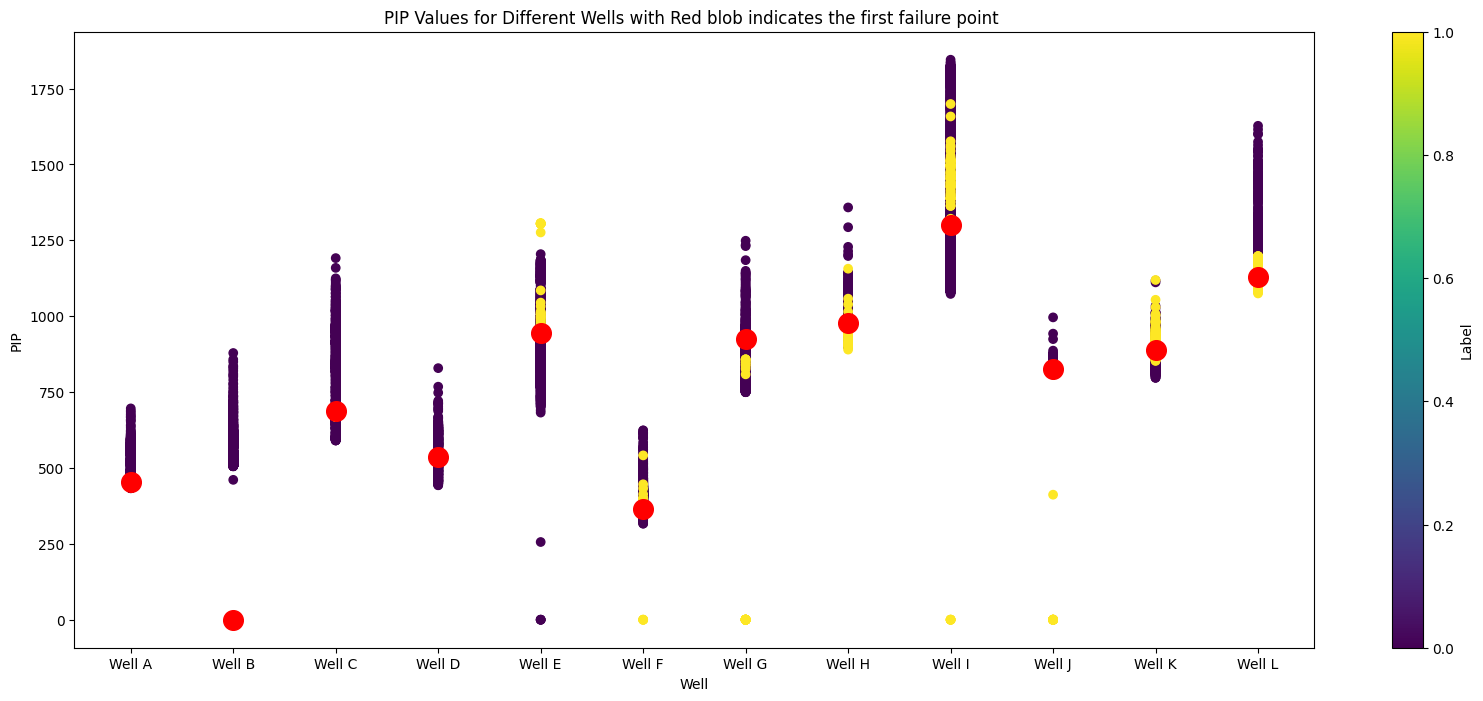

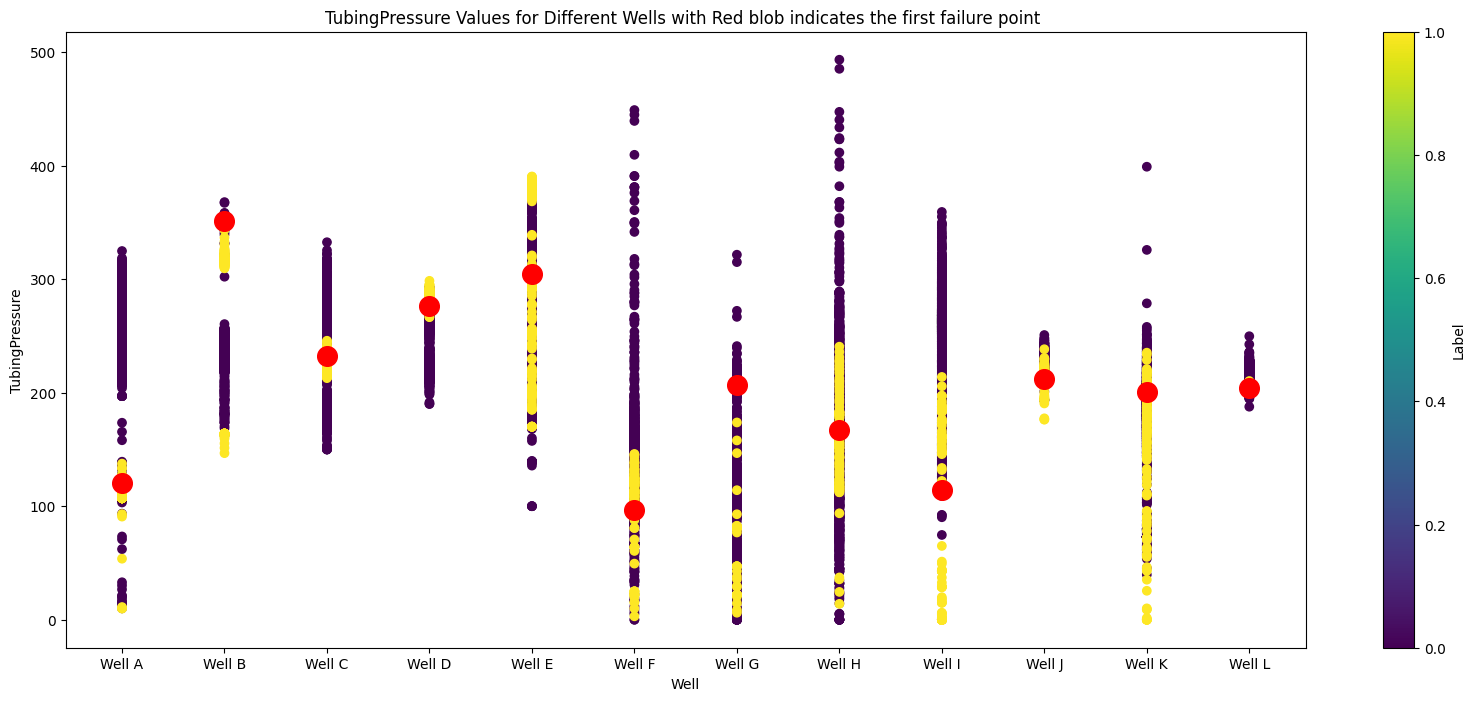

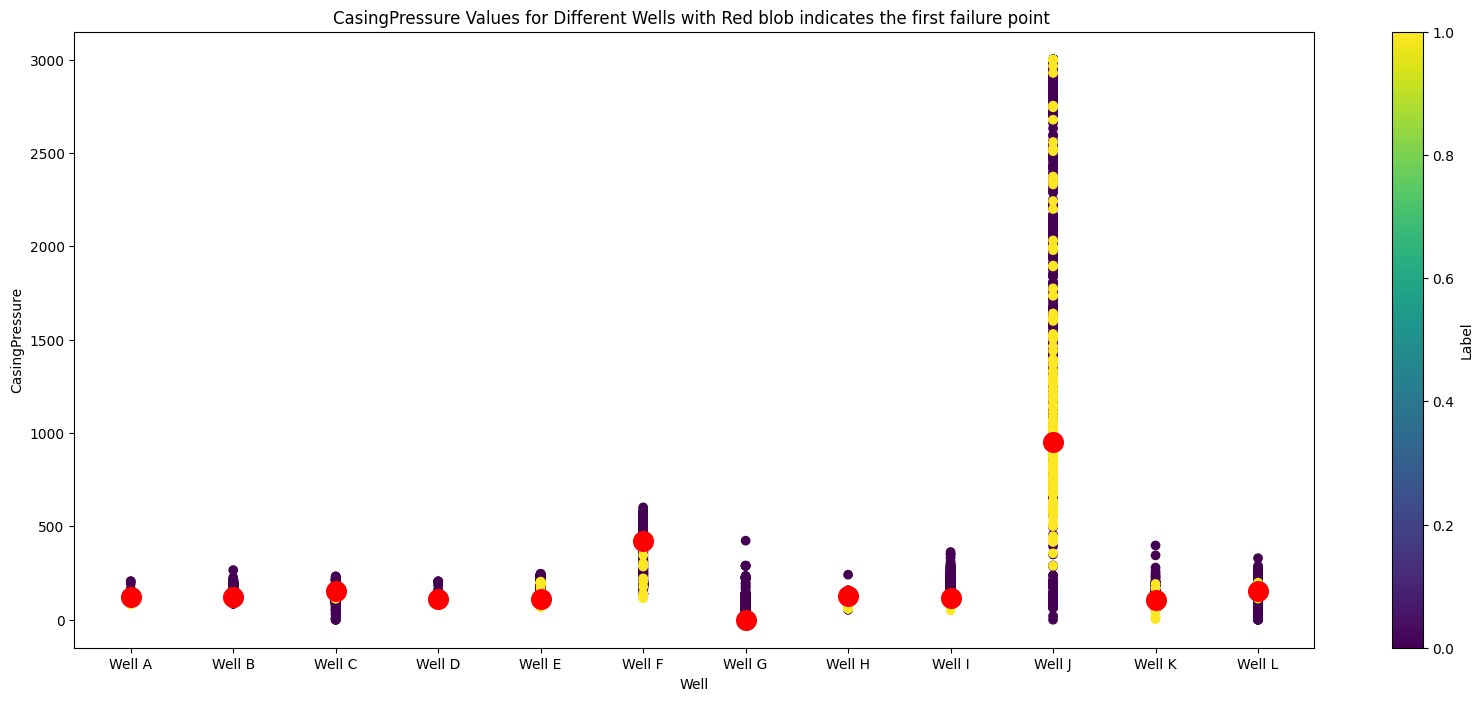

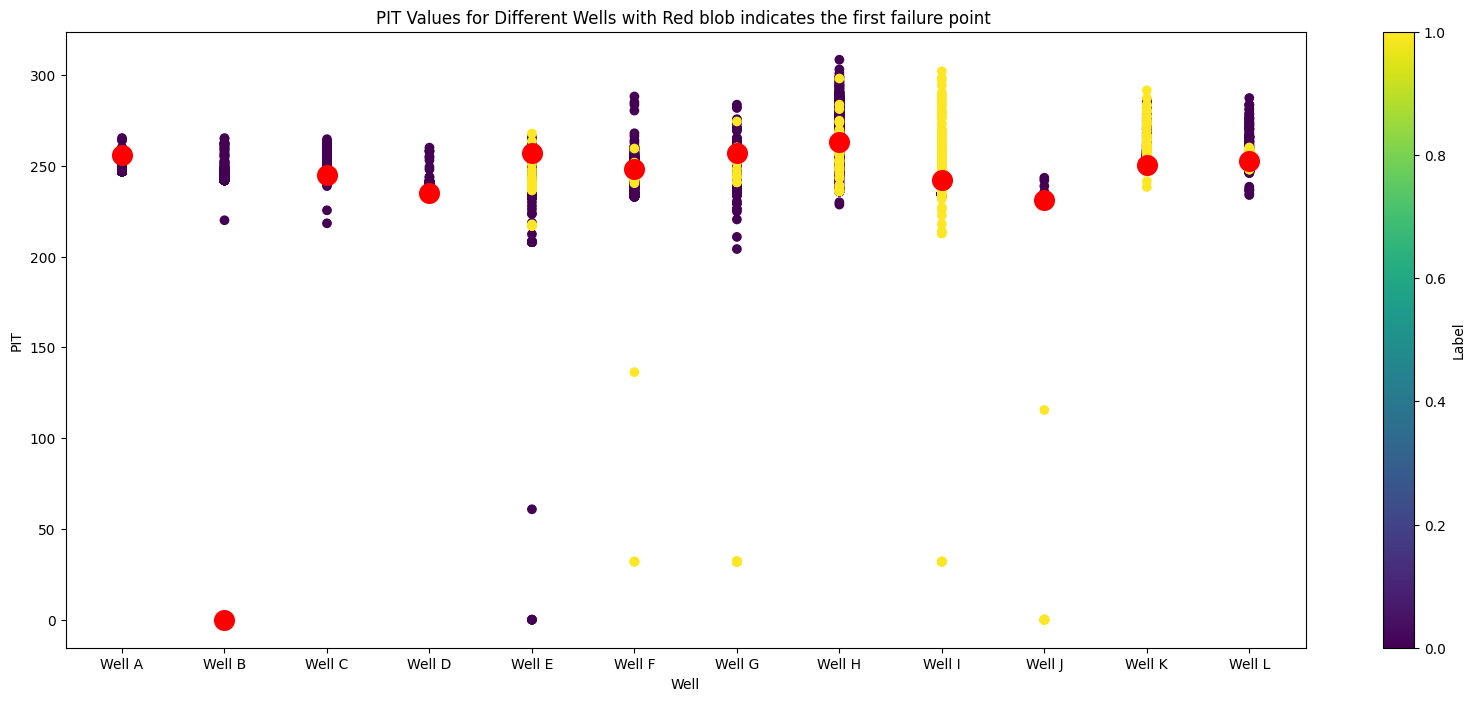

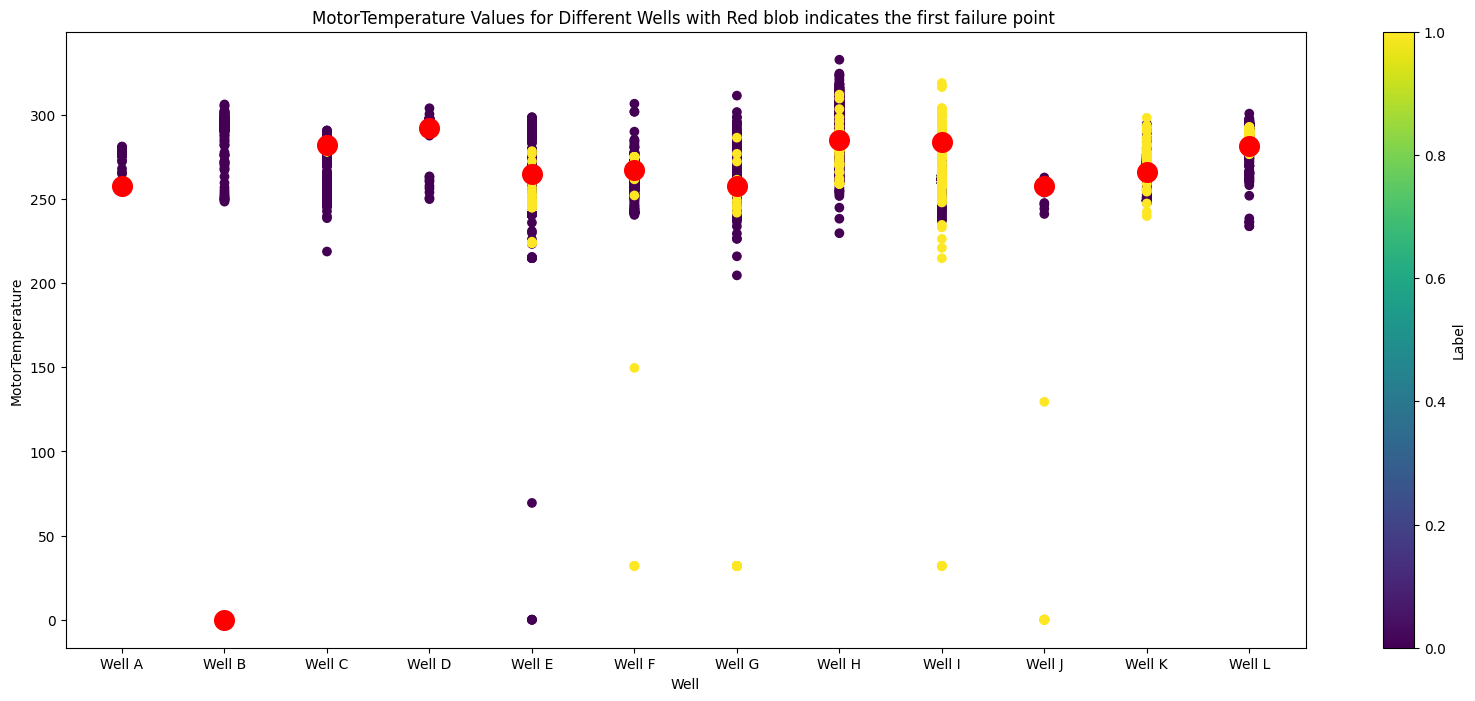

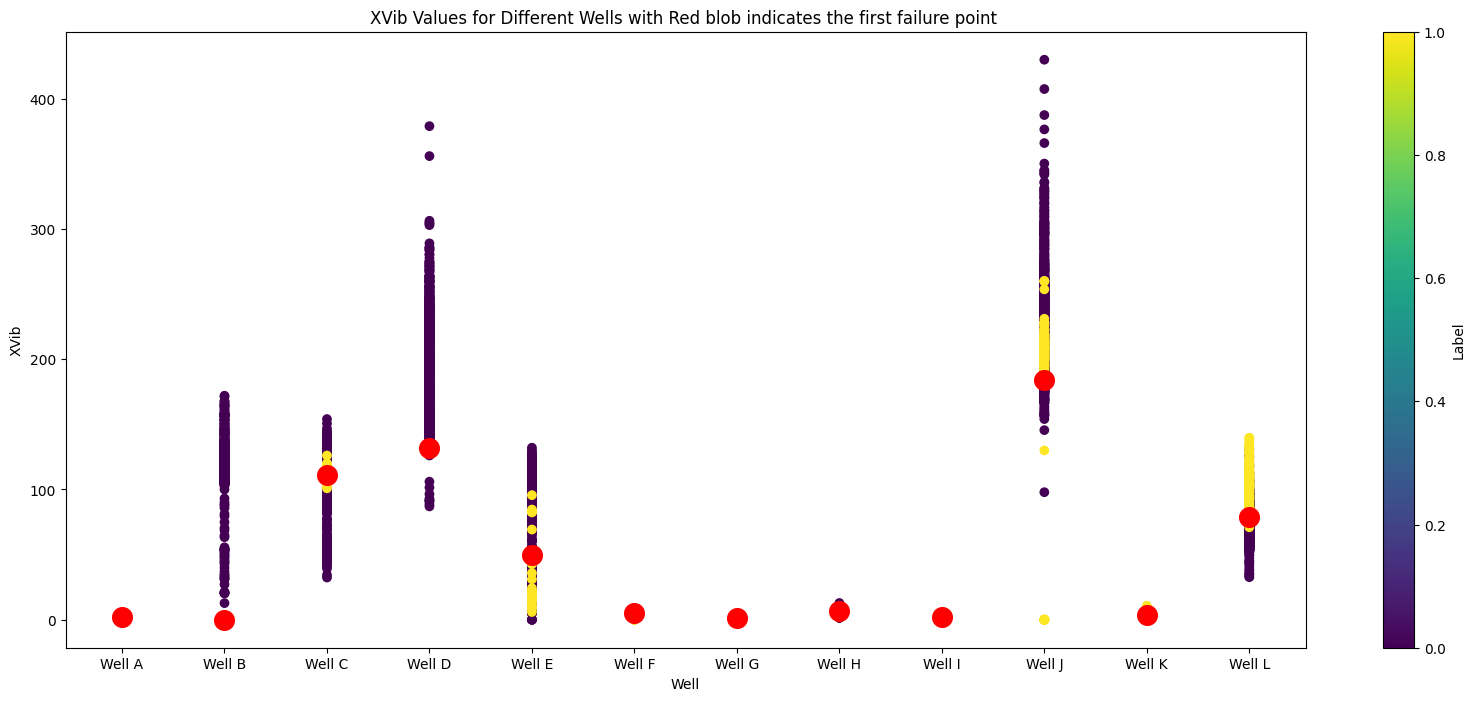

In [ ]:
# Create a scatter plot of the Columns for each well with the points coloured according to their Label value
# Red blob indicates the first failure point
columns = ['Frequency',	'PIP',	'TubingPressure',	'CasingPressure','PIT',	'MotorTemperature',	'XVib']
for column in columns:
  plt.figure(figsize=(20, 8))
  plt.scatter(data['NodeID'], data[column], c=data['Label'])

  # add a blob near the first failure point for each category in NodeID
  failure_points = data[data['Label'] == 1].groupby('NodeID').first()
  for index, row in failure_points.iterrows():
      plt.scatter(index, row[column], s=200, c='r', marker='o')


  plt.xlabel('Well')
  plt.ylabel(column)
  plt.title(f'{column} Values for Different Wells with Red blob indicates the first failure point ')
  plt.colorbar(label='Label')

  plt.show()

## Time series plot for 'MotorCurrent'

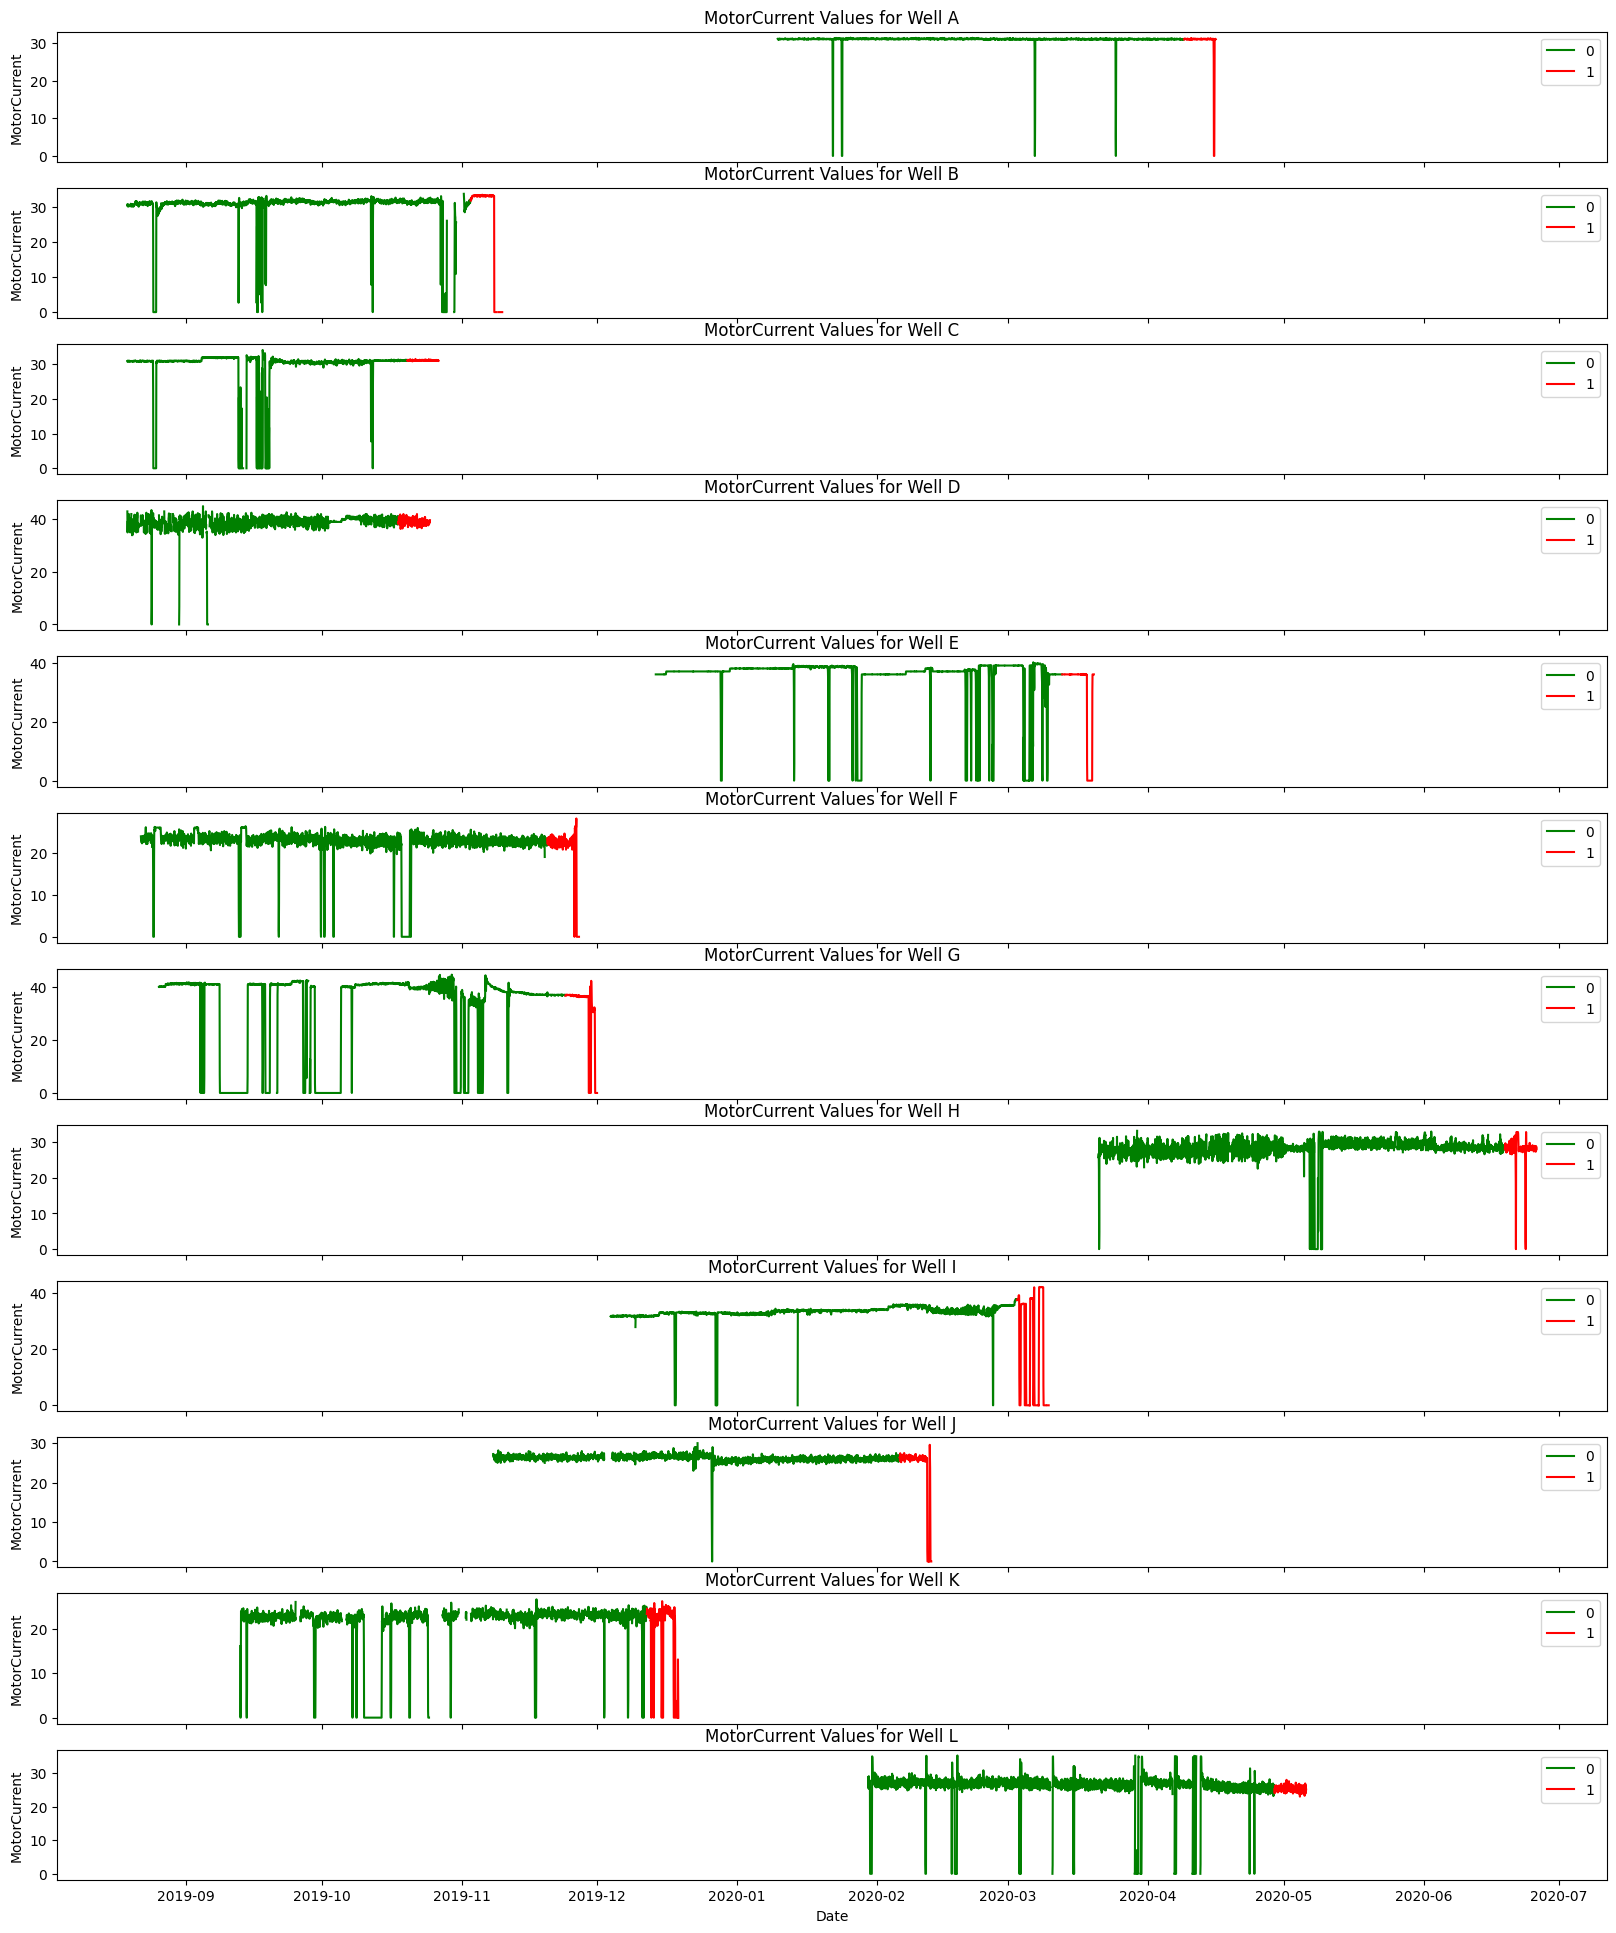

In [ ]:
temp_data = data.set_index('Date')
grouped_data = temp_data.groupby('NodeID')

fig, axs = plt.subplots(len(grouped_data), figsize=(20,len(grouped_data)*2), sharex=True)

colors = ['green', 'red']

for ax,(name, group) in zip(axs.flatten(),grouped_data):
    for label, label_group in group.groupby('Label'):
        ax.plot(label_group.index, label_group['MotorCurrent'], label=label, color=colors[int(label)])
    ax.legend()
    ax.set_ylabel('MotorCurrent')
    ax.set_title(f'MotorCurrent Values for {name}')

plt.xlabel('Date')
plt.show()

# Feature Engineering

## Correlation
Checking correlation amoung features to check if there is a possibility of dimensionality reduction

<ipython-input-18-266f7a6e6668>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



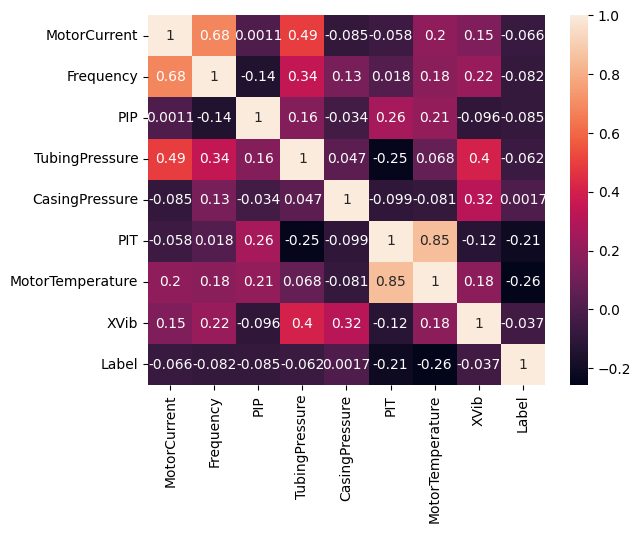

In [ ]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True)
plt.show()

## Outlier


In [ ]:
data.describe()

MotorCurrent     Frequency           PIP  TubingPressure  \
count  25625.000000  25625.000000  25625.000000    25625.000000   
mean      29.001035     54.362822    835.531786      203.872787   
std        8.436798     12.846042    307.271353       64.228736   
min        0.000000      0.000000      0.000000        0.000000   
25%       25.650000     53.716667    567.428571      160.916667   
50%       30.750000     57.833333    859.000000      217.136364   
75%       33.545455     60.000000    999.000000      244.727273   
max       45.000000     64.083333   1845.250000      493.250000   

       CasingPressure           PIT  MotorTemperature          XVib  \
count    25625.000000  25625.000000      25625.000000  25625.000000   
mean       218.355574    242.890239        270.984579     59.822666   
std        409.166812     26.525505         30.894704     73.982932   
min          0.000000      0.000000          0.000000      0.000000   
25%        104.666667    235.000000        261.250000      2.000000   
50%        127.083333    245.000000        273.500000      6.250000   
75%        185.000000    252.000000        285.833333    109.083333   
max       3000.000000    308.416667        332.833333    430.000000   

              Label  
count  26220.000000  
mean       0.077346  
std        0.267144  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [ ]:
# Create the box plot
for column in columns:
  fig = px.box(data, x='NodeID', y=column, color='NodeID')
  fig.show()

## Adding time series features

In [ ]:
timed_data = data.set_index('Date')

In [ ]:
timed_data = create_features(timed_data)
display(timed_data.head())
display(timed_data.shape)

NodeID  MotorCurrent  Frequency         PIP  \
Date                                                               
2020-01-10 00:00:00  Well A     31.083333  58.916667  599.000000   
2020-01-10 01:00:00  Well A     31.000000  59.000000  598.500000   
2020-01-10 02:00:00  Well A     30.916667  59.000000  598.416667   
2020-01-10 03:00:00  Well A     31.000000  58.909091  597.181818   
2020-01-10 04:00:00  Well A     31.000000  59.454545  604.000000   

                     TubingPressure  CasingPressure         PIT  \
Date                                                              
2020-01-10 00:00:00           211.0      118.000000  247.000000   
2020-01-10 01:00:00           204.0      118.000000  247.000000   
2020-01-10 02:00:00           197.0      118.000000  247.000000   
2020-01-10 03:00:00           197.0      119.272727  247.000000   
2020-01-10 04:00:00           197.0      132.000000  247.454545   

                     MotorTemperature      XVib  Label  hour  dayofweek  \
Date                                                                      
2020-01-10 00:00:00        277.333333  2.083333      0     0          4   
2020-01-10 01:00:00        277.416667  2.250000      0     1          4   
2020-01-10 02:00:00        277.416667  2.000000      0     2          4   
2020-01-10 03:00:00        277.181818  2.000000      0     3          4   
2020-01-10 04:00:00        278.181818  2.000000      0     4          4   

                     month  year  dayofyear  dayofmonth  
Date                                                     
2020-01-10 00:00:00      1  2020         10          10  
2020-01-10 01:00:00      1  2020         10          10  
2020-01-10 02:00:00      1  2020         10          10  
2020-01-10 03:00:00      1  2020         10          10  
2020-01-10 04:00:00      1  2020         10          10

(26220, 16)

# Modelling Part 1 ( Naive Approach)

In [ ]:
model1_data = timed_data.drop('NodeID',axis=1)

## Train,Val,Test split

In [ ]:
train_df,test_df=train_test_split(model1_data,0.2)
train_df,val_df=train_test_split(train_df,0.2)

print(f'Train size={train_df.shape},Val Size={val_df.shape} Test Size={test_df.shape}')

Train size=(16780, 15),Val Size=(4196, 15) Test Size=(5244, 15)


## Missing values

In [ ]:

print('TRAIN')
print_nan_vals(train_df)
print('VAL')
print_nan_vals(val_df)
print('TEST')
print_nan_vals(test_df)

TRAIN


NAN Value distribution:

MotorCurrent        253
Frequency           253
PIP                 253
TubingPressure      253
CasingPressure      253
PIT                 253
MotorTemperature    253
XVib                253
Label                 0
hour                  0
dayofweek             0
month                 0
year                  0
dayofyear             0
dayofmonth            0
dtype: int64

The DataFrame contains 253 rows with at least one NaN value.

Total missing value rows = 253 / 16780
VAL


NAN Value distribution:

MotorCurrent        62
Frequency           62
PIP                 62
TubingPressure      62
CasingPressure      62
PIT                 62
MotorTemperature    62
XVib                62
Label                0
hour                 0
dayofweek            0
month                0
year                 0
dayofyear            0
dayofmonth           0
dtype: int64

The DataFrame contains 62 rows with at least one NaN value.

Total missing value rows = 62 / 4196
TEST

In [ ]:
train_df.head()

MotorCurrent  Frequency         PIP  TubingPressure  \
Date                                                                       
2020-01-10 00:00:00     31.083333  58.916667  599.000000           211.0   
2020-01-10 01:00:00     31.000000  59.000000  598.500000           204.0   
2020-01-10 02:00:00     30.916667  59.000000  598.416667           197.0   
2020-01-10 03:00:00     31.000000  58.909091  597.181818           197.0   
2020-01-10 04:00:00     31.000000  59.454545  604.000000           197.0   

                     CasingPressure         PIT  MotorTemperature      XVib  \
Date                                                                          
2020-01-10 00:00:00      118.000000  247.000000        277.333333  2.083333   
2020-01-10 01:00:00      118.000000  247.000000        277.416667  2.250000   
2020-01-10 02:00:00      118.000000  247.000000        277.416667  2.000000   
2020-01-10 03:00:00      119.272727  247.000000        277.181818  2.000000   
2020-01-10 04:00:00      132.000000  247.454545        278.181818  2.000000   

                     Label  hour  dayofweek  month  year  dayofyear  \
Date                                                                  
2020-01-10 00:00:00      0     0          4      1  2020         10   
2020-01-10 01:00:00      0     1          4      1  2020         10   
2020-01-10 02:00:00      0     2          4      1  2020         10   
2020-01-10 03:00:00      0     3          4      1  2020         10   
2020-01-10 04:00:00      0     4          4      1  2020         10   

                     dayofmonth  
Date                             
2020-01-10 00:00:00          10  
2020-01-10 01:00:00          10  
2020-01-10 02:00:00          10  
2020-01-10 03:00:00          10  
2020-01-10 04:00:00          10

In [ ]:
#Rechecking
train_df = linear_interpolate(train_df)
val_df = linear_interpolate(val_df)
test_df = linear_interpolate(test_df)
print('TRAIN')
print_nan_vals(train_df)
print('VAL')
print_nan_vals(val_df)
print('TEST')
print_nan_vals(test_df)

TRAIN


NAN Value distribution:

MotorCurrent        0
Frequency           0
PIP                 0
TubingPressure      0
CasingPressure      0
PIT                 0
MotorTemperature    0
XVib                0
Label               0
hour                0
dayofweek           0
month               0
year                0
dayofyear           0
dayofmonth          0
dtype: int64

The DataFrame contains 0 rows with at least one NaN value.

Total missing value rows = 0 / 16780
VAL


NAN Value distribution:

MotorCurrent        0
Frequency           0
PIP                 0
TubingPressure      0
CasingPressure      0
PIT                 0
MotorTemperature    0
XVib                0
Label               0
hour                0
dayofweek           0
month               0
year                0
dayofyear           0
dayofmonth          0
dtype: int64

The DataFrame contains 0 rows with at least one NaN value.

Total missing value rows = 0 / 4196
TEST


NAN Value distribution:

MotorCurrent        0
F

In [ ]:
train_df.head()

MotorCurrent  Frequency         PIP  TubingPressure  \
Date                                                                       
2020-01-10 00:00:00     31.083333  58.916667  599.000000           211.0   
2020-01-10 01:00:00     31.000000  59.000000  598.500000           204.0   
2020-01-10 02:00:00     30.916667  59.000000  598.416667           197.0   
2020-01-10 03:00:00     31.000000  58.909091  597.181818           197.0   
2020-01-10 04:00:00     31.000000  59.454545  604.000000           197.0   

                     CasingPressure         PIT  MotorTemperature      XVib  \
Date                                                                          
2020-01-10 00:00:00      118.000000  247.000000        277.333333  2.083333   
2020-01-10 01:00:00      118.000000  247.000000        277.416667  2.250000   
2020-01-10 02:00:00      118.000000  247.000000        277.416667  2.000000   
2020-01-10 03:00:00      119.272727  247.000000        277.181818  2.000000   
2020-01-10 04:00:00      132.000000  247.454545        278.181818  2.000000   

                     Label  hour  dayofweek  month  year  dayofyear  \
Date                                                                  
2020-01-10 00:00:00      0     0          4      1  2020         10   
2020-01-10 01:00:00      0     1          4      1  2020         10   
2020-01-10 02:00:00      0     2          4      1  2020         10   
2020-01-10 03:00:00      0     3          4      1  2020         10   
2020-01-10 04:00:00      0     4          4      1  2020         10   

                     dayofmonth  
Date                             
2020-01-10 00:00:00          10  
2020-01-10 01:00:00          10  
2020-01-10 02:00:00          10  
2020-01-10 03:00:00          10  
2020-01-10 04:00:00          10

##XGBoost without crossval

### Transforming data for ML

In [ ]:
X_train,y_train= df_to_X_y1(train_df,window_size=100)
X_val,y_val = df_to_X_y1(val_df,window_size=100)
X_test,y_test = df_to_X_y1(test_df,window_size=100)



print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(16675, 1500) (16675,)
(4091, 1500) (4091,)
(5139, 1500) (5139,)


### Feature Transformation

Used Min Max Scalar

In [ ]:
X_train= pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

scaler = MinMaxScaler()   # Formual : x_normalized = (x - min) / (max - min)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
print(y_train)

[0. 0. 0. ... 1. 1. 1.]


### Modelling

In [ ]:
# Hyperparameter ref : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
model = XGBClassifier(base_score=0.5, booster='gbtree',
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective='binary:logistic',
                        max_depth=3,
                        learning_rate=0.01)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)



[0]	validation_0-logloss:0.68337	validation_1-logloss:0.68352
[100]	validation_0-logloss:0.20879	validation_1-logloss:0.21893
[200]	validation_0-logloss:0.08054	validation_1-logloss:0.08643
[300]	validation_0-logloss:0.03782	validation_1-logloss:0.04338
[400]	validation_0-logloss:0.02241	validation_1-logloss:0.02834
[498]	validation_0-logloss:0.01435	validation_1-logloss:0.02702


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
# # Modelling using grid search CV

# # Define the parameter grid
# param_grid = {

#     'n_estimators': [300,500],
#     'max_depth': [2,3],
#     'learning_rate': [0.01,0.05]
# }

# # Create an XGBClassifier object
# xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree',
#                         objective='binary:logistic')

# # GridSearchCV
# grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid,cv=2,n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best parameters
# best_params = grid_search.best_params_
# print(f"Best parameters: {best_params}")

# # Get the best estimator
# model = grid_search.best_estimator_

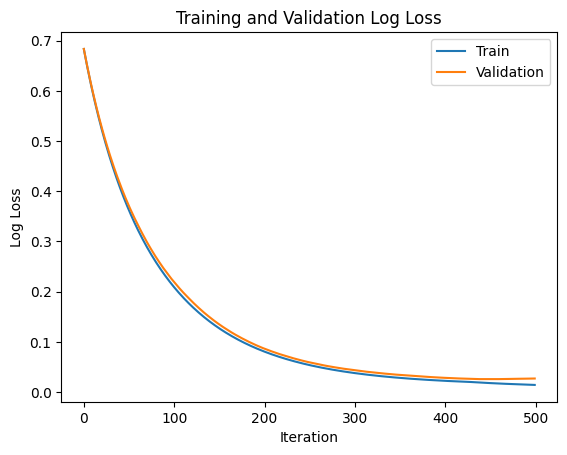

In [ ]:
# get evaluation results
evals_result = model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
val_logloss = evals_result['validation_1']['logloss']

# plot log loss curves
plt.plot(train_logloss, label='Train')
plt.plot(val_logloss, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss')
plt.legend()
plt.show()

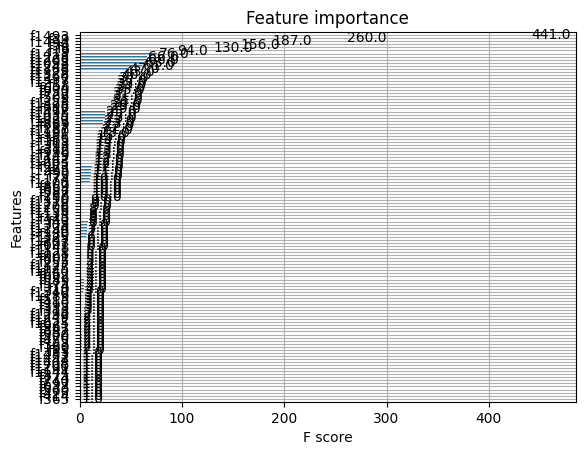

In [ ]:
# Get feature importances
plot_importance(model)
pyplot.show()

### Inference


 Log loss : 0.1586 
 


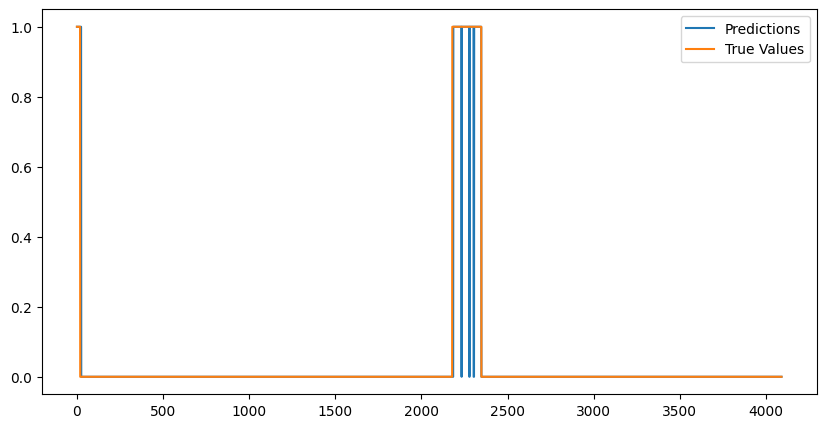


 Recall: 0.9361702127659575 
 


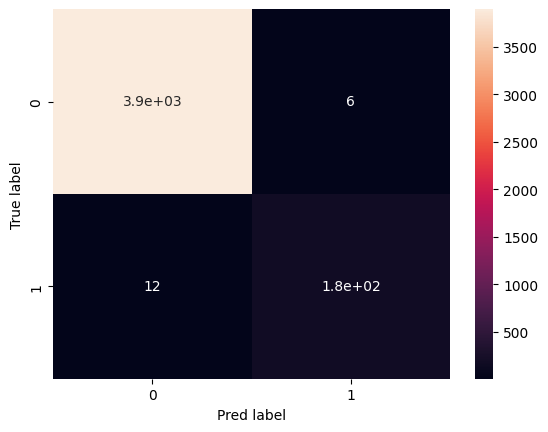

In [ ]:
# Validation set analysis

y_pred = model.predict(X_val)
plot_pred_vs_true(y_pred,y_val)


 Log loss : 0.2104 
 


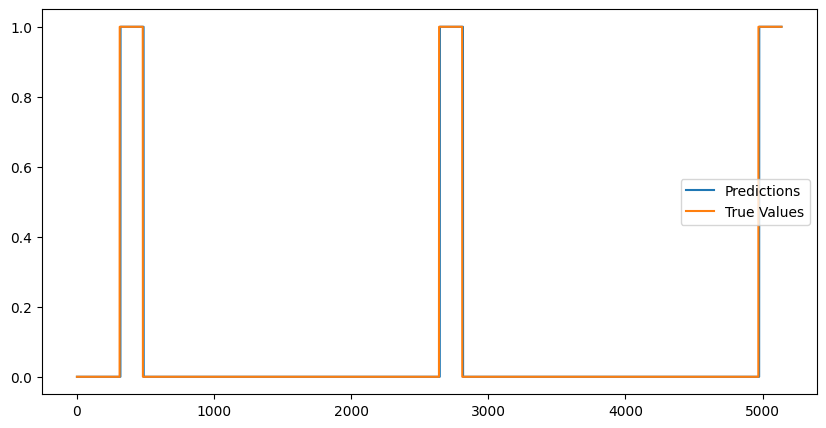


 Recall: 0.9644970414201184 
 


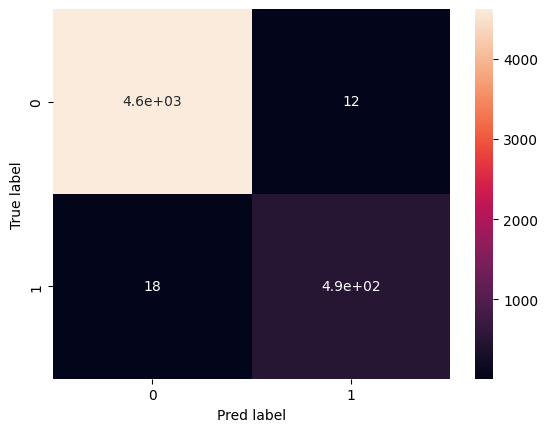

In [ ]:
# Test dataset analysis

y_pred = model.predict(X_test)
plot_pred_vs_true(y_pred,y_test)

## XGBoost with cross val

### Data preperation

In [ ]:
# Test train split
train_df,test_df=train_test_split(model1_data,0.2)

# Interpolation
train_df = linear_interpolate(train_df)
test_df = linear_interpolate(test_df)

# Data Preperation
X_train,y_train= df_to_X_y1(train_df,window_size=100)
X_test,y_test = df_to_X_y1(test_df,window_size=100)

# Feature transformation
X_train= pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

scaler = MinMaxScaler()   # Formual : x_normalized = (x - min) / (max - min)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)




In [ ]:
# Join X_train and y_train
train_df = pd.DataFrame(X_train)
test_df = pd.DataFrame(X_test)

train_df['Label']=y_train
test_df['Label']=y_test
train_df.head()

0         1         2         3         4         5         6  \
0  0.690741  0.919376  0.324617  0.427775  0.039333  0.800865  0.833250   
1  0.688889  0.920676  0.324346  0.413583  0.039333  0.800865  0.833500   
2  0.687037  0.920676  0.324301  0.399392  0.039333  0.800865  0.833500   
3  0.688889  0.919258  0.323632  0.399392  0.039758  0.800865  0.832795   
4  0.688889  0.927769  0.327327  0.399392  0.044000  0.802338  0.835799   

          7    8         9  ...      1491      1492  1493      1494      1495  \
0  0.004845  0.0  0.000000  ...  0.832248  0.004651   0.0  0.130435  0.166667   
1  0.005233  0.0  0.043478  ...  0.834502  0.005233   0.0  0.173913  0.166667   
2  0.004651  0.0  0.086957  ...  0.833500  0.005039   0.0  0.217391  0.166667   
3  0.004651  0.0  0.130435  ...  0.833751  0.004457   0.0  0.260870  0.166667   
4  0.004651  0.0  0.173913  ...  0.833751  0.004651   0.0  0.304348  0.166667   

   1496  1497      1498      1499  Label  
0   0.0   1.0  0.035714  0.433333    0.0  
1   0.0   1.0  0.035714  0.433333    0.0  
2   0.0   1.0  0.035714  0.433333    0.0  
3   0.0   1.0  0.035714  0.433333    0.0  
4   0.0   1.0  0.035714  0.433333    0.0  

[5 rows x 1501 columns]

### Crossval visualization

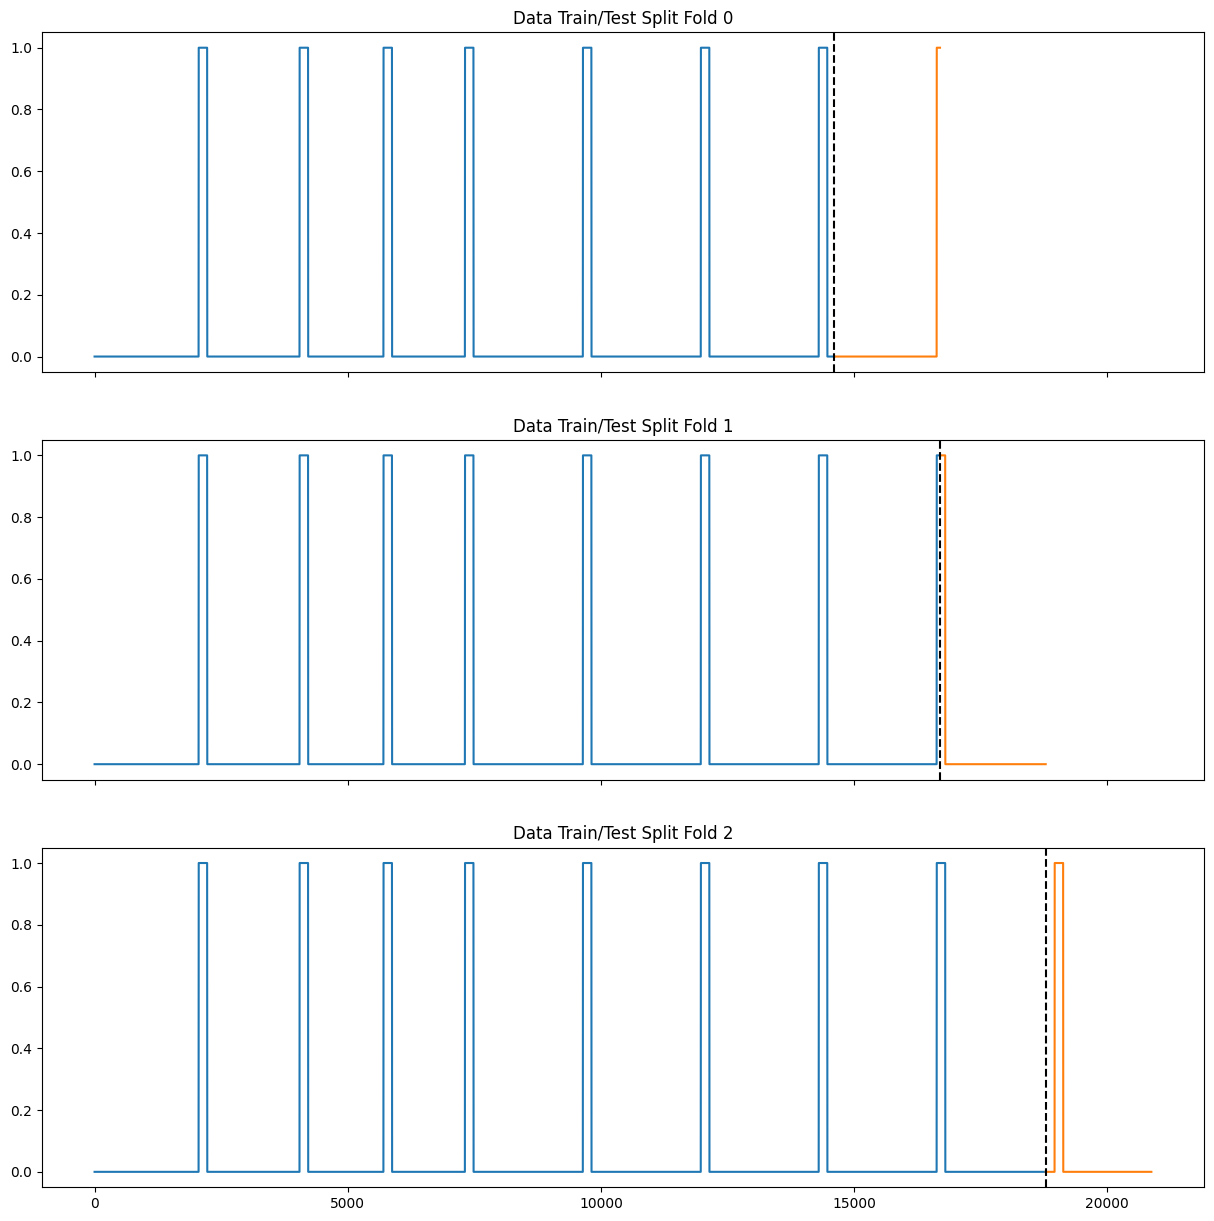

In [ ]:
n_splits =3

def plot_crossval(df,n_splits=4):
  tss = TimeSeriesSplit(n_splits=n_splits, test_size = int(df.shape[0]*0.3/n_splits) )

  fig, axs = plt.subplots(n_splits, 1, figsize=(15, 15), sharex=True)
  fold = 0
  for train_idx, val_idx in tss.split(X_train):
      train = df.iloc[train_idx]
      validate = df.iloc[val_idx]
      train['Label'].plot(ax=axs[fold],
                            label='Training Set',
                            title=f'Data Train/Test Split Fold {fold}')
      validate['Label'].plot(ax=axs[fold],
                          label='Test Set')
      axs[fold].axvline(validate.index.min(), color='black', ls='--')
      fold += 1
  plt.show()
plot_crossval(train_df,n_splits)

### Modelling

In [ ]:
n_splits=3

tss = TimeSeriesSplit(n_splits=n_splits, test_size=40)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_df):
    train = train_df.iloc[train_idx]
    val = train_df.iloc[val_idx]


    X_train = train.drop('Label',axis=1)
    y_train = train['Label']

    X_val = val.drop('Label',axis=1)
    y_val = val['Label']

    model = XGBClassifier(base_score=0.5, booster='gbtree',
                            n_estimators=500,
                            early_stopping_rounds=10,
                            objective='binary:logistic',
                            max_depth=3,
                            learning_rate=0.01)
    model.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = model.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(log_loss(y_test, y_pred))
    scores.append(score)


[0]	validation_0-logloss:0.68338	validation_1-logloss:0.68325
[100]	validation_0-logloss:0.20919	validation_1-logloss:0.20248
[200]	validation_0-logloss:0.08103	validation_1-logloss:0.07163
[300]	validation_0-logloss:0.03827	validation_1-logloss:0.02736
[400]	validation_0-logloss:0.02292	validation_1-logloss:0.01123
[499]	validation_0-logloss:0.01631	validation_1-logloss:0.00528
[0]	validation_0-logloss:0.68338	validation_1-logloss:0.68325
[100]	validation_0-logloss:0.20917	validation_1-logloss:0.20216
[200]	validation_0-logloss:0.08100	validation_1-logloss:0.07062
[300]	validation_0-logloss:0.03824	validation_1-logloss:0.02622
[400]	validation_0-logloss:0.02289	validation_1-logloss:0.01021
[499]	validation_0-logloss:0.01628	validation_1-logloss:0.00437
[0]	validation_0-logloss:0.68338	validation_1-logloss:0.68325
[100]	validation_0-logloss:0.20916	validation_1-logloss:0.20246
[200]	validation_0-logloss:0.08099	validation_1-logloss:0.07162
[300]	validation_0-logloss:0.03822	validation_

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.4103
Fold scores:[0.4102803471875622, 0.4102803471875622, 0.4102803471875622]



 Log loss : 0.1683 
 


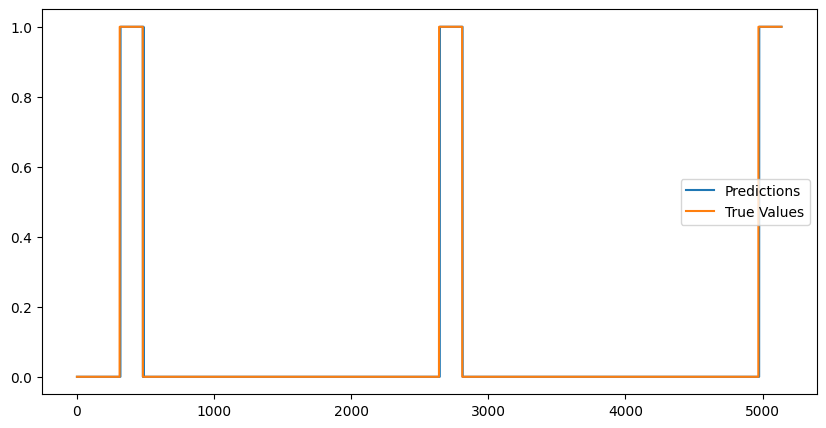


 Recall: 0.9644970414201184 
 


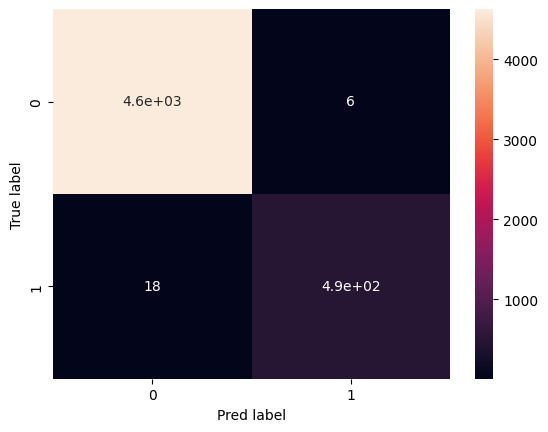

In [ ]:
# Test Dataset analysis

y_pred = model.predict(X_test)

# plot
plot_pred_vs_true(y_pred,test_df['Label'])

## RandomForest Classifier

In [ ]:
# Test train split
train_df,test_df=train_test_split(model1_data,0.2)
train_df,val_df=train_test_split(train_df,0.2)

# Interpolation
train_df = linear_interpolate(train_df)
val_df = linear_interpolate(val_df)
test_df = linear_interpolate(test_df)

# Data Preperation
X_train,y_train= df_to_X_y1(train_df,window_size=100)
X_val,y_val = df_to_X_y1(val_df,window_size=100)
X_val,y_val = df_to_X_y1(val_df,window_size=100)

# Feature transformation
X_train= pd.DataFrame(X_train)
X_val = pd.DataFrame(X_val)
X_test = pd.DataFrame(X_test)

scaler = MinMaxScaler()   # Formual : x_normalized = (x - min) / (max - min)
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)



In [ ]:
model = RandomForestClassifier(n_estimators=100,max_depth=2,max_leaf_nodes=25,bootstrap=False)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=2, max_leaf_nodes=25)


 Log loss : 0.4993 
 


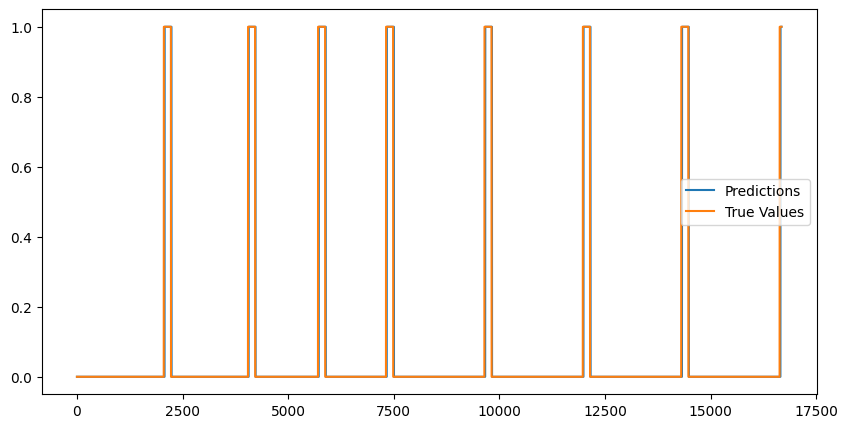


 Recall: 0.8835504885993485 
 


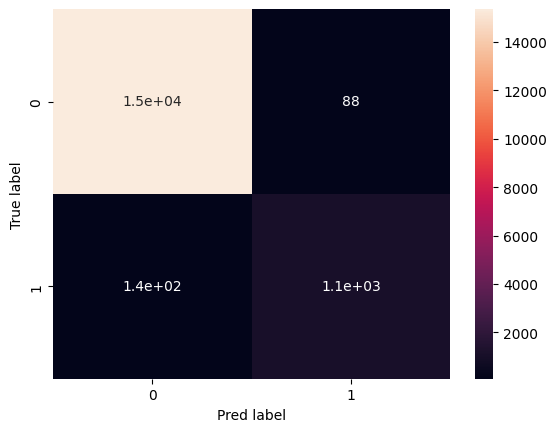

In [ ]:
# Train dataset analysis


y_pred = model.predict(X_train)

# Plot

plot_pred_vs_true(y_pred,y_train)


 Log loss : 0.4229 
 


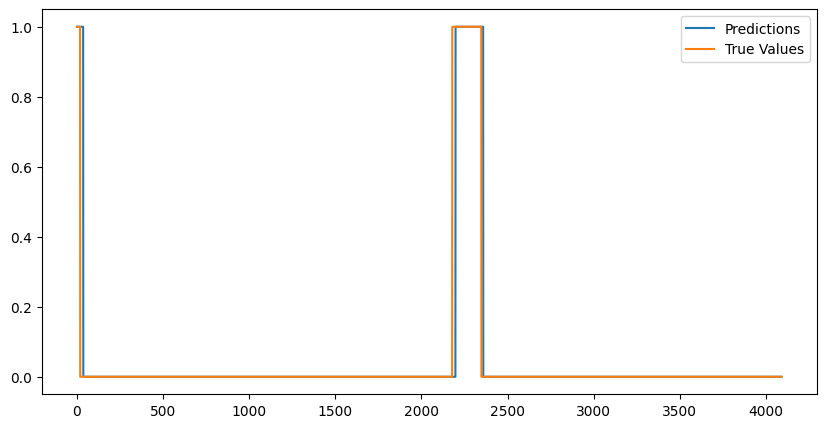


 Recall: 0.898936170212766 
 


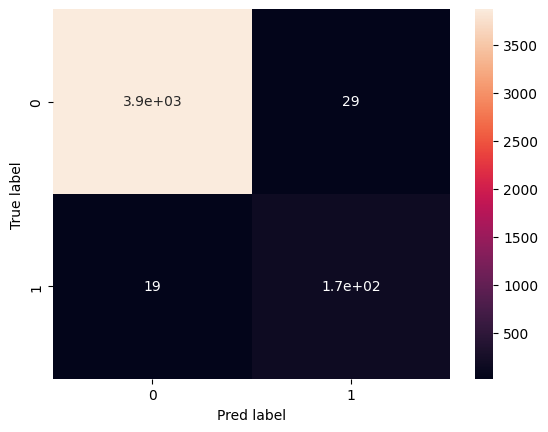

In [ ]:
# Val dataset analysis

y_pred = model.predict(X_val)

# Plot
plot_pred_vs_true(y_pred,y_val)


 Log loss : 0.6102 
 


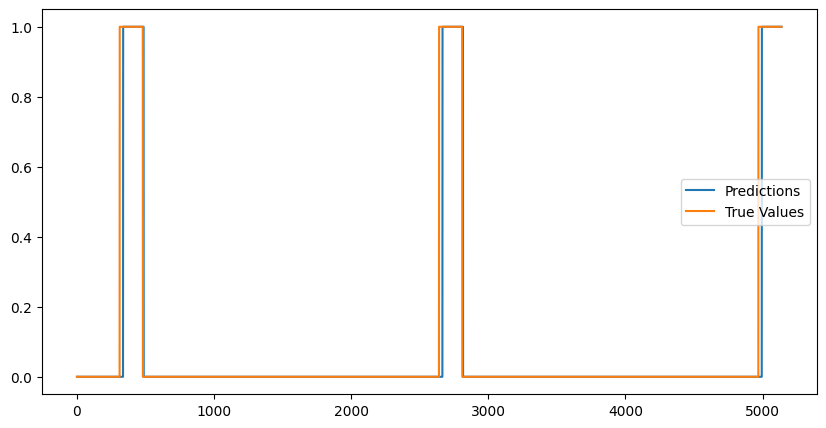


 Recall: 0.8520710059171598 
 


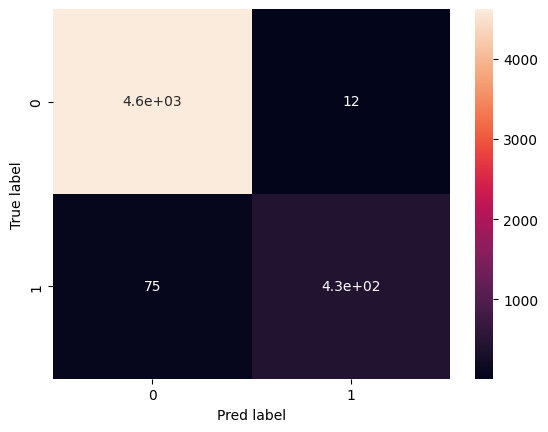

In [ ]:
# Test dataset analysis

y_pred = model.predict(X_test)

# Plot
plot_pred_vs_true(y_pred,y_test)

# Problems with the above approach

*   We have to predict the point where the label changes from 0 -> 1 which in the given dataset has only 12 of them
*   Predicting label from 1 -> 1 or 1- > 0 is happening in the previous method which is not the objective
*   Combining all wells and then doing the windowing might cause the data of 2 different wells to mix and its not advisable as we have seen the data distribution of different wells are different from each other
*   We have got high recall from the previous modelling because it had a lot of 1 -> 1 predictions which is not the objective and it was not able to infer how much meaningful forcast of 0 -> 1 was made




# Modelling Part 2 (Advanced)

*   List item
*   List item



In [ ]:
timed_data.head()

NodeID  MotorCurrent  Frequency         PIP  \
Date                                                               
2020-01-10 00:00:00  Well A     31.083333  58.916667  599.000000   
2020-01-10 01:00:00  Well A     31.000000  59.000000  598.500000   
2020-01-10 02:00:00  Well A     30.916667  59.000000  598.416667   
2020-01-10 03:00:00  Well A     31.000000  58.909091  597.181818   
2020-01-10 04:00:00  Well A     31.000000  59.454545  604.000000   

                     TubingPressure  CasingPressure         PIT  \
Date                                                              
2020-01-10 00:00:00           211.0      118.000000  247.000000   
2020-01-10 01:00:00           204.0      118.000000  247.000000   
2020-01-10 02:00:00           197.0      118.000000  247.000000   
2020-01-10 03:00:00           197.0      119.272727  247.000000   
2020-01-10 04:00:00           197.0      132.000000  247.454545   

                     MotorTemperature      XVib  Label  hour  dayofweek  \
Date                                                                      
2020-01-10 00:00:00        277.333333  2.083333      0     0          4   
2020-01-10 01:00:00        277.416667  2.250000      0     1          4   
2020-01-10 02:00:00        277.416667  2.000000      0     2          4   
2020-01-10 03:00:00        277.181818  2.000000      0     3          4   
2020-01-10 04:00:00        278.181818  2.000000      0     4          4   

                     month  year  dayofyear  dayofmonth  
Date                                                     
2020-01-10 00:00:00      1  2020         10          10  
2020-01-10 01:00:00      1  2020         10          10  
2020-01-10 02:00:00      1  2020         10          10  
2020-01-10 03:00:00      1  2020         10          10  
2020-01-10 04:00:00      1  2020         10          10

### Dictionary of Dataframes

In [ ]:
# Creatind seperate dataframes for each well and storing them in a dictionary

# Assume df is your input DataFrame
grouped = timed_data.groupby('NodeID')

# Create a dictionary to store the DataFrames for each category
dfs = {}

for node_id, group in grouped:
    dfs[node_id] = group


# Check
dfs['Well A'].shape

(2329, 16)

In [ ]:
### Retaining only the first change from 0 -> 1 and removing all other datapoints
for well in dfs:
    idx = dfs[well][dfs[well]['Label'].diff() == 1].index[0]
    dfs[well] = dfs[well].loc[:idx]


### Preprocssing

In [ ]:
# Preprocessing for all dataframes in the dictionary

for well in dfs:
  dfs[well].drop('NodeID',axis=1,inplace=True)
  X,y= df_to_X_y1(dfs[well],window_size=100)
  if well == 'Well A':
    X_comb = pd.DataFrame(X)
    y_comb = pd.DataFrame(y)

  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  X_comb= pd.concat([pd.DataFrame(X), X_comb], axis=0)
  y_comb= pd.concat([pd.DataFrame(y), y_comb], axis=0)


<ipython-input-268-ace688e74e81>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:

X_train,X_test=train_test_split(X_comb,0.2)
y_train,y_test = train_test_split(y_comb,0.2)
X_train,X_val= train_test_split(X_train,0.2)
y_train,y_val = train_test_split(y_train,0.2)
print(f'Train size={X_train.shape},Val Size={X_val.shape} Test Size={X_test.shape}')
print(f'Train size={y_train.shape},Val Size={y_val.shape} Test Size={y_test.shape}')



Train size=(16000, 1500),Val Size=(4000, 1500) Test Size=(5000, 1500)
Train size=(16000, 1),Val Size=(4000, 1) Test Size=(5000, 1)


### Missing value interpolation

In [ ]:
X_train = linear_interpolate(X_train)
X_val = linear_interpolate(X_val)
X_test = linear_interpolate(X_test)

In [ ]:
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()
y_test = y_test.to_numpy()

## Modelling with XGB

In [ ]:
model = XGBClassifier(base_score=0.5, booster='gbtree',
                        n_estimators=100,
                        early_stopping_rounds=10,
                        objective='binary:logistic',
                        max_depth=2,
                        learning_rate=0.1)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=100)


[0]	validation_0-logloss:0.59833	validation_1-logloss:0.59839
[99]	validation_0-logloss:0.00038	validation_1-logloss:0.00219


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

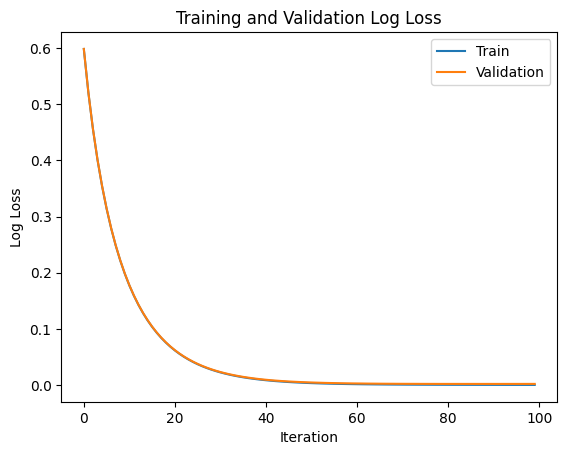

In [ ]:
# get evaluation results
evals_result = model.evals_result()
train_logloss = evals_result['validation_0']['logloss']
val_logloss = evals_result['validation_1']['logloss']

# plot log loss curves
plt.plot(train_logloss, label='Train')
plt.plot(val_logloss, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training and Validation Log Loss')
plt.legend()
plt.show()


 Log loss : 0.0180 
 


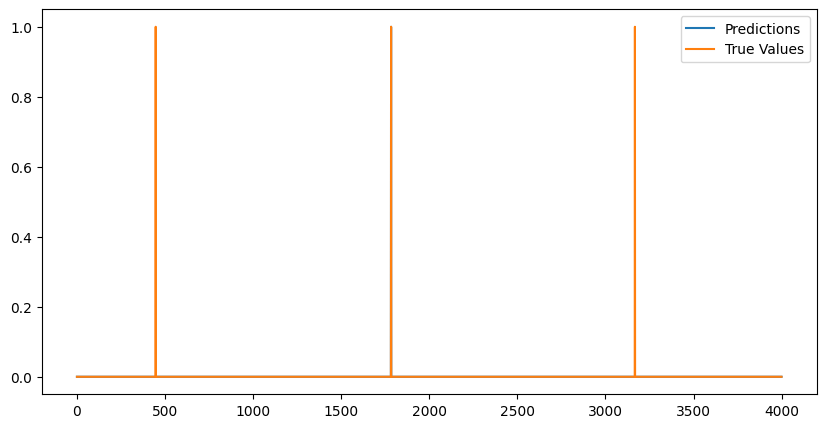


 Recall: 0.3333333333333333 
 


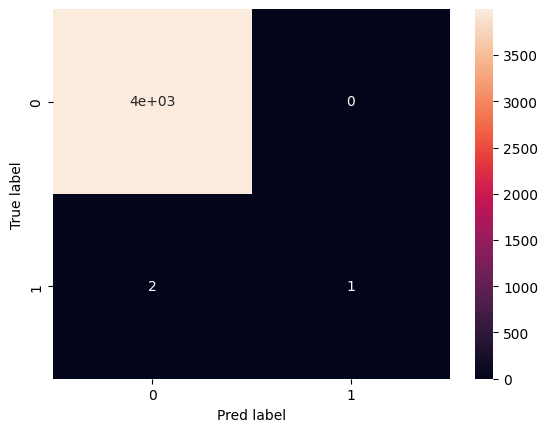

In [ ]:

y_pred = model.predict(X_val)
plot_pred_vs_true(y_pred,y_val)


 Log loss : 0.0072 
 


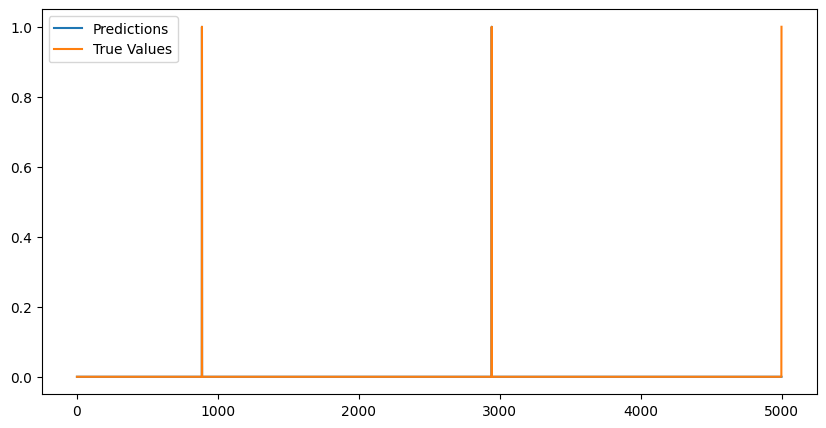


 Recall: 0.6666666666666666 
 


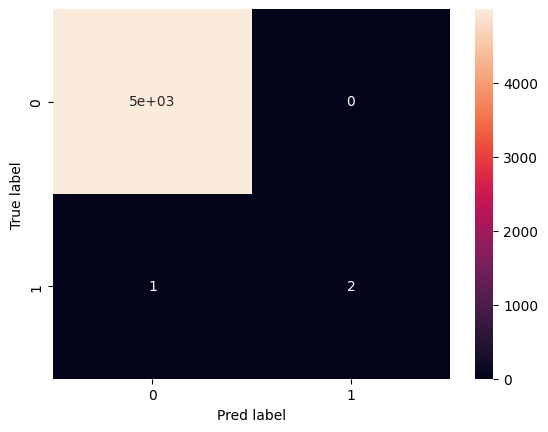

In [ ]:
# get predicted probabilities
y_pred = model.predict(X_test)

# Plot
plot_pred_vs_true(y_pred,y_test)

## Modelling with RandomForest

In [ ]:
model = RandomForestClassifier(n_estimators=50,max_depth=3,max_leaf_nodes=50,bootstrap = False)
model.fit(X_train, y_train)

<ipython-input-296-5382e45c0c0a>:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(bootstrap=False, max_depth=3, max_leaf_nodes=50,
                       n_estimators=50)


 Log loss : 0.0023 
 


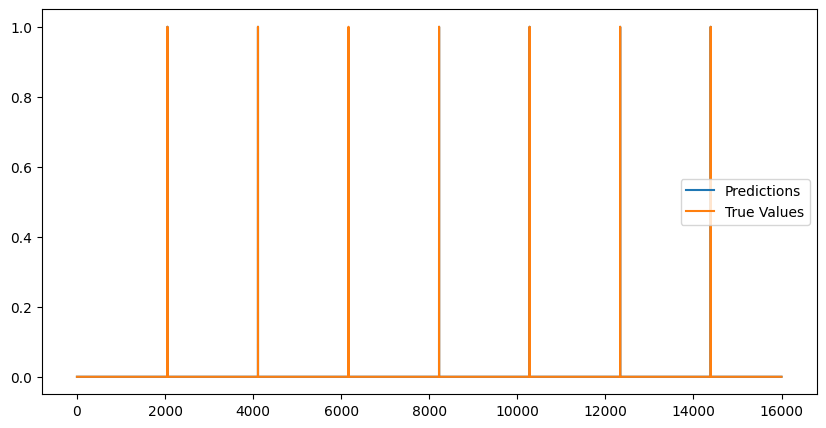


 Recall: 0.8571428571428571 
 


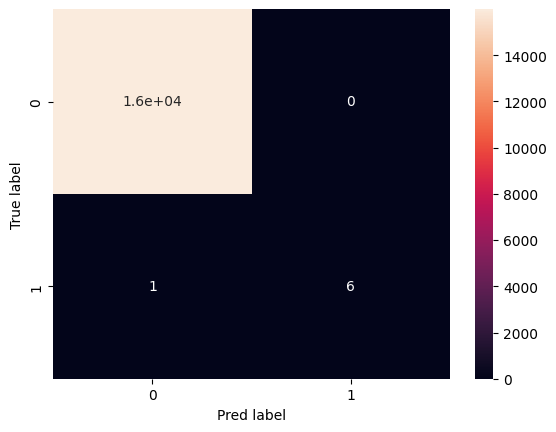

In [ ]:
# Train set anlaysis

y_pred = model.predict(X_train)

# Plot
plot_pred_vs_true(y_pred,y_train)


 Log loss : 0.0090 
 


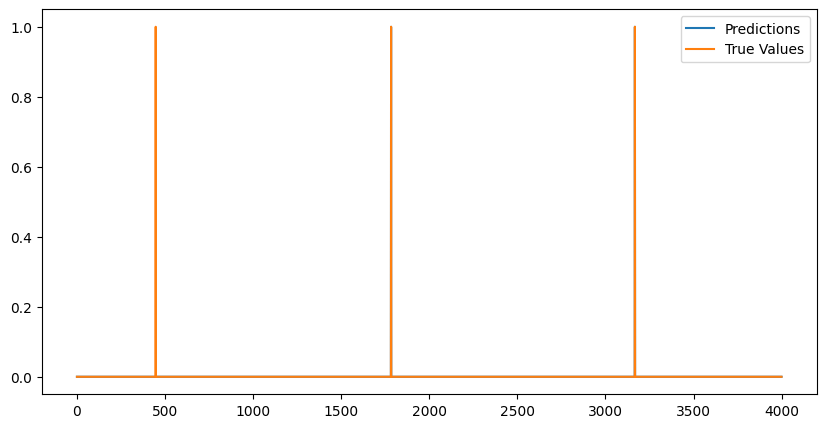


 Recall: 0.6666666666666666 
 


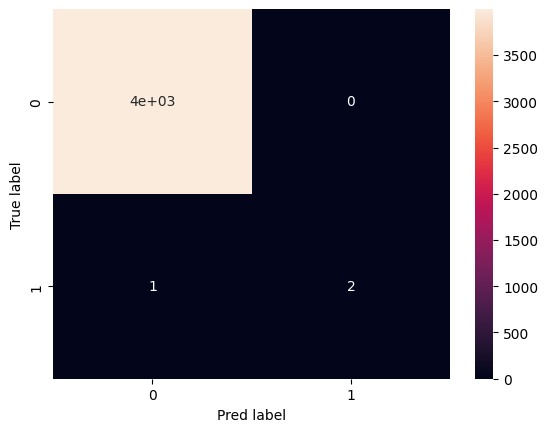

In [ ]:
# Val set analysis

y_pred = model.predict(X_val)

# Plot
plot_pred_vs_true(y_pred,y_val)


 Log loss : 0.0072 
 


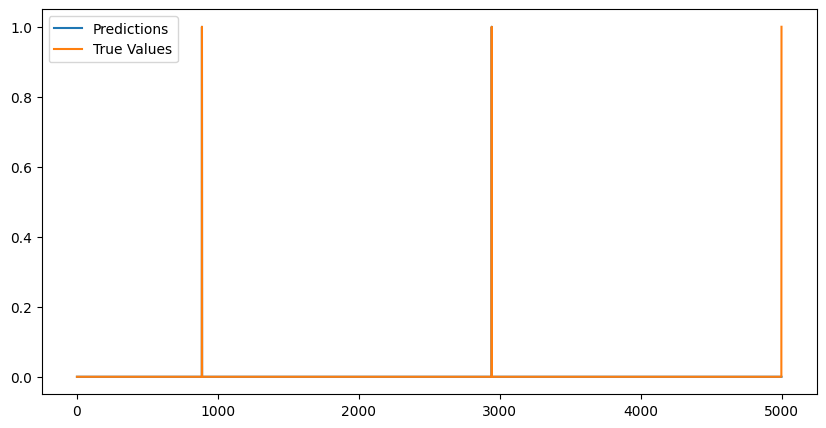


 Recall: 0.6666666666666666 
 


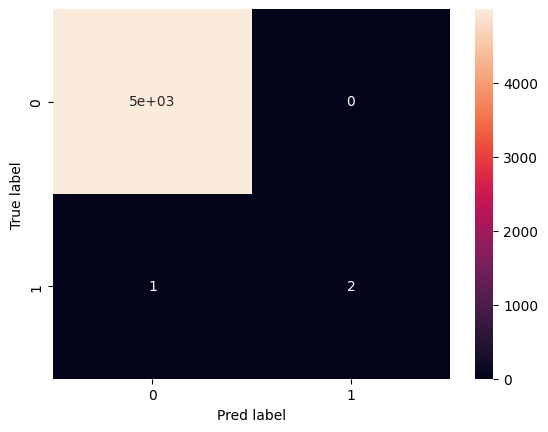

In [ ]:
# Test set analysis

y_pred = model.predict(X_test)

# Plot
plot_pred_vs_true(y_pred,y_test)

# Deep learning approach

## Naive Method

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

### Data Prep

In [ ]:
model2_data = model1_data.copy()

# Test train split
train_df,test_df=train_test_split(model2_data,0.2)
train_df,val_df = train_test_split(train_df,0.2)

scaler = MinMaxScaler()   # Formual : x_normalized = (x - min) / (max - min)
train_df = scaler.fit_transform(train_df)
val_df = scaler.fit_transform(val_df)
test_df = scaler.transform(test_df)

scaled_data= pd.concat([pd.DataFrame(train_df),pd.DataFrame(val_df), pd.DataFrame(test_df)], axis=0)

# Test train split
train_df,test_df=train_test_split(scaled_data,0.2)
train_df,val_df = train_test_split(train_df,0.2)

train_df=linear_interpolate(train_df)
val_df = linear_interpolate (val_df)
test_df = linear_interpolate(test_df)


X_train,y_train= df_to_X_y2(train_df,window_size=100)
X_val, y_val = df_to_X_y2(val_df,window_size=100)
X_test,y_test = df_to_X_y2(test_df,window_size=100)




print(f'Train size={X_train.shape},Val size={X_val.shape}, Test Size={X_test.shape}')
print(f'Train size={y_train.shape},Val size={y_val.shape}, Test Size={y_test.shape}')




Train size=(16675, 100, 15),Val size=(4091, 100, 15), Test Size=(5139, 100, 15)
Train size=(16675,),Val size=(4091,), Test Size=(5139,)


### LSTM

In [ ]:

model1 = Sequential()
model1.add(InputLayer((100, 15)))
model1.add(LSTM(24))
model1.add(Dense(4, 'relu'))
model1.add(Dense(1, 'sigmoid'))

model1.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24)                3840      
                                                                 
 dense_24 (Dense)            (None, 4)                 100       
                                                                 
 dense_25 (Dense)            (None, 1)                 5         
                                                                 
Total params: 3,945
Trainable params: 3,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(learning_rate=0.02),
              metrics=[Recall()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp1])

Epoch 1/5
522/522 [==============================] - ETA: 0s - loss: 0.0525 - recall_8: 0.8721

522/522 [==============================] - 36s 64ms/step - loss: 0.0525 - recall_8: 0.8721 - val_loss: 0.0238 - val_recall_8: 0.9628
Epoch 2/5
521/522 [============================>.] - ETA: 0s - loss: 0.0308 - recall_8: 0.9609

522/522 [==============================] - 33s 63ms/step - loss: 0.0308 - recall_8: 0.9609 - val_loss: 0.0215 - val_recall_8: 0.9681
Epoch 3/5
522/522 [==============================] - 24s 45ms/step - loss: 0.0290 - recall_8: 0.9609 - val_loss: 0.0220 - val_recall_8: 0.9681
Epoch 4/5
522/522 [==============================] - 24s 45ms/step - loss: 0.0279 - recall_8: 0.9609 - val_loss: 0.0224 - val_recall_8: 0.9681
Epoch 5/5
522/522 [==============================] - 25s 48ms/step - loss: 0.0279 - recall_8: 0.9609 - val_loss: 0.0215 - val_recall_8: 0.9681


#### Inference

In [ ]:
model1 = load_model('model1/')

522/522 [==============================] - 6s 11ms/step

 Log loss : 0.0860 
 


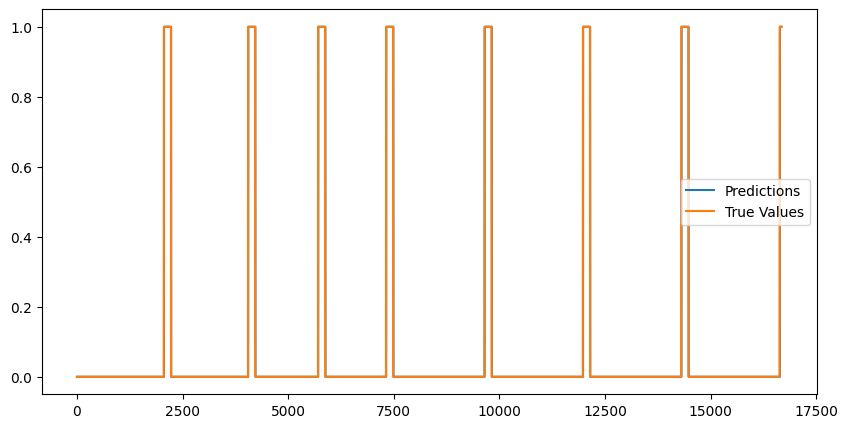


 Recall: 0.9609120521172638 
 


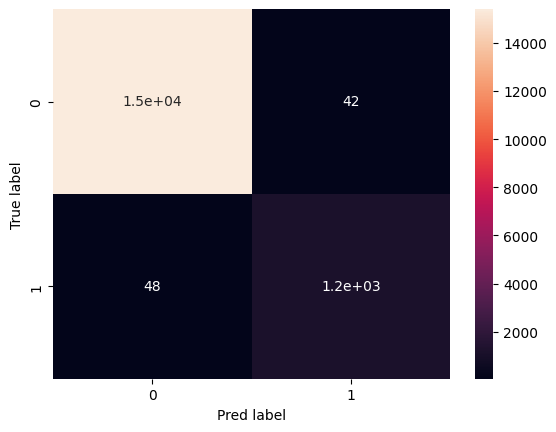

In [ ]:
# Train data analysis
y_pred = model1.predict(X_train).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_train)


128/128 [==============================] - 1s 11ms/step

 Log loss : 0.0701 
 


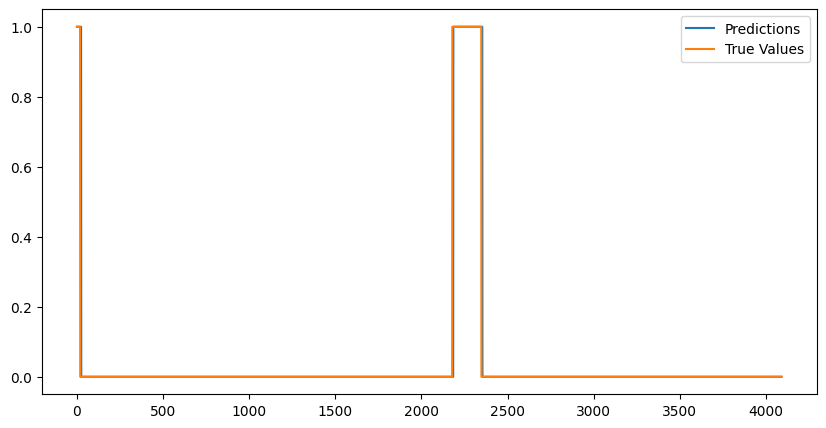


 Recall: 0.9680851063829787 
 


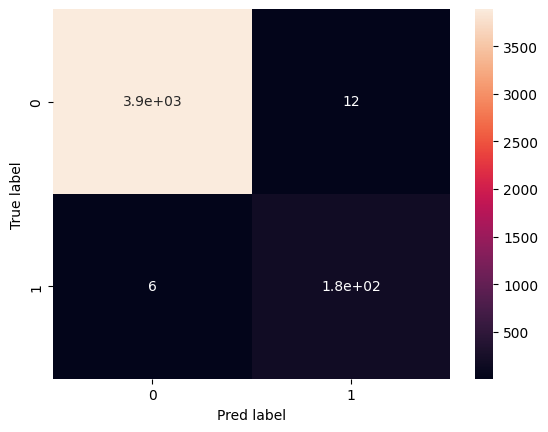

In [ ]:
# Val set analysis

y_pred = model1.predict(X_val).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_val)

161/161 [==============================] - 2s 11ms/step

 Log loss : 0.0931 
 


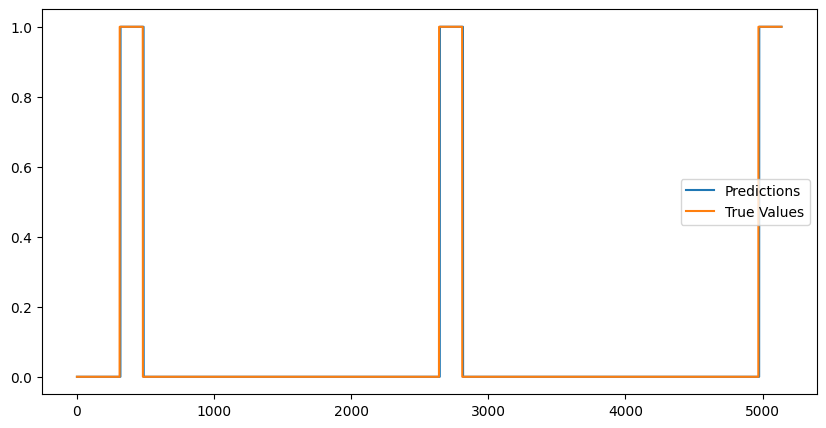


 Recall: 0.9644970414201184 
 


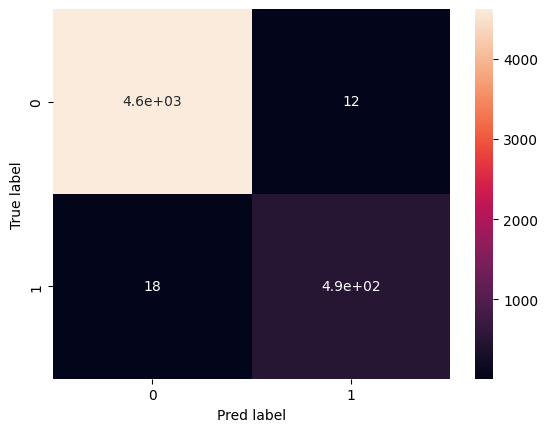

In [ ]:
# Test set analysis

y_pred = model1.predict(X_test).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_test)


### CNN

In [ ]:
model2 = Sequential()
model2.add(InputLayer((100, 15)))
model2.add(Conv1D(16, kernel_size=3))
model2.add(Flatten())
model2.add(Dense(16, 'relu'))
model2.add(Dense(1, 'sigmoid'))

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 98, 16)            736       
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_26 (Dense)            (None, 16)                25104     
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(learning_rate=0.02),
              metrics=[Recall()])

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp2])

Epoch 1/20
513/522 [============================>.] - ETA: 0s - loss: 0.1477 - recall_9: 0.8580

522/522 [==============================] - 5s 8ms/step - loss: 0.1456 - recall_9: 0.8599 - val_loss: 0.0317 - val_recall_9: 0.9415
Epoch 2/20
515/522 [============================>.] - ETA: 0s - loss: 0.0354 - recall_9: 0.9235

522/522 [==============================] - 3s 6ms/step - loss: 0.0352 - recall_9: 0.9243 - val_loss: 0.0307 - val_recall_9: 0.9415
Epoch 3/20
512/522 [============================>.] - ETA: 0s - loss: 0.0312 - recall_9: 0.9469

522/522 [==============================] - 3s 6ms/step - loss: 0.0308 - recall_9: 0.9479 - val_loss: 0.0279 - val_recall_9: 0.9574
Epoch 4/20
515/522 [============================>.] - ETA: 0s - loss: 0.0277 - recall_9: 0.9367

522/522 [==============================] - 4s 7ms/step - loss: 0.0281 - recall_9: 0.9357 - val_loss: 0.0227 - val_recall_9: 0.9362
Epoch 5/20
522/522 [==============================] - 3s 5ms/step - loss: 0.2302 - recall_9: 0.3355 - val_loss: 0.1943 - val_recall_9: 0.0000e+00
Epoch 6/20
522/522 [==============================] - 2s 4ms/step - loss: 0.2631 - recall_9: 0.0000e+00 - val_loss: 0.1924 - val_recall_9: 0.0000e+00
Epoch 7/20
522/522 [==============================] - 2s 4ms/step - loss: 0.2633 - recall_9: 0.0000e+00 - val_loss: 0.1933 - val_recall_9: 0.0000e+00
Epoch 8/20
522/522 [==============================] - 2s 4ms/step - loss: 0.2631 - recall_9: 0.0000e+00 - val_loss: 0.1908 - val_recall_9: 0.0000e+00
Epoch 9/20
522/522 [==============================] - 3s 5ms/step - loss: 0.2632 - recall_9: 0.0000e+00 - val_loss: 0.1945 - val_recall_9: 0.0000e+00
Epoch 10/20
522/522 [==============================] - 3s 5ms/step - loss: 0.2632 - recall_9: 0.0000e+00 - val_loss: 0.1950

##### Inference

In [ ]:
model2 = load_model('model1/')

522/522 [==============================] - 6s 11ms/step

 Log loss : 0.0860 
 


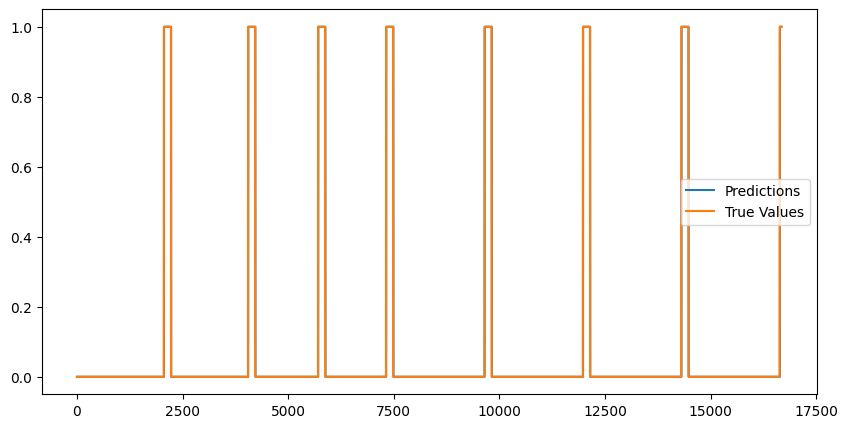


 Recall: 0.9609120521172638 
 


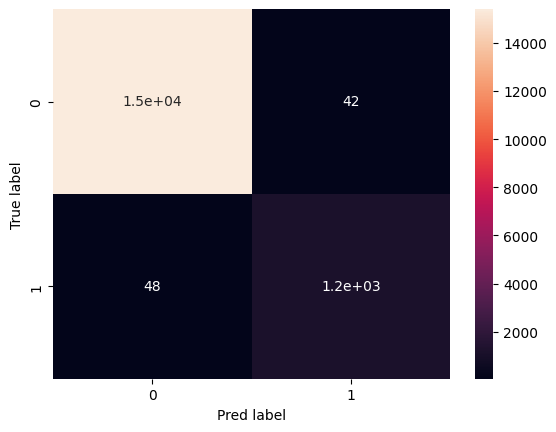

In [ ]:
# Train data analysis
y_pred = model1.predict(X_train).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_train)


128/128 [==============================] - 2s 12ms/step

 Log loss : 0.0701 
 


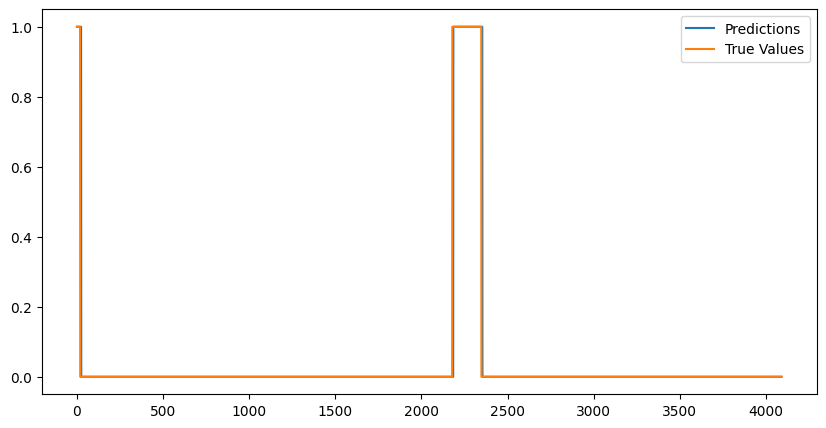


 Recall: 0.9680851063829787 
 


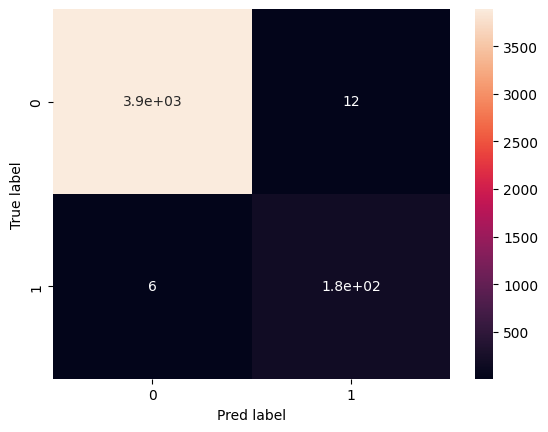

In [ ]:
# Val set analysis

y_pred = model1.predict(X_val).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_val)

161/161 [==============================] - 2s 11ms/step

 Log loss : 0.0931 
 


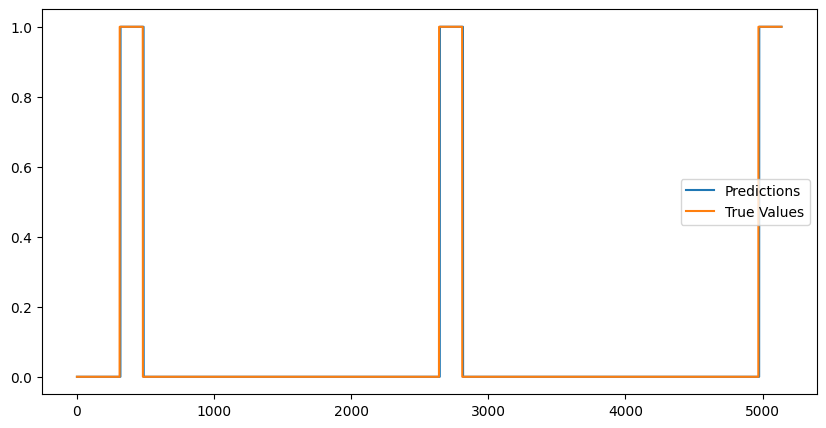


 Recall: 0.9644970414201184 
 


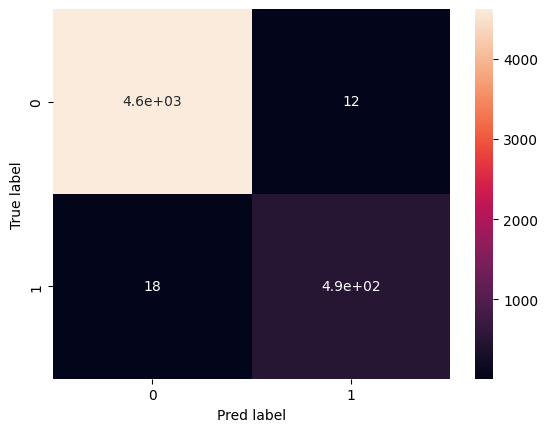

In [ ]:
# Test set analysis

y_pred = model1.predict(X_test).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_test)


## Advanced Method

In [ ]:
# Creatind seperate dataframes for each well and storing them in a dictionary

# Assume df is your input DataFrame
grouped = timed_data.groupby('NodeID')

# Create a dictionary to store the DataFrames for each category
dfs = {}

for node_id, group in grouped:
    dfs[node_id] = group


# Check
dfs['Well A'].shape

(2329, 16)

In [ ]:
### Retaining only the first change from 0 -> 1 and removing all other datapoints
for well in dfs:
    idx = dfs[well][dfs[well]['Label'].diff() == 1].index[0]
    dfs[well] = dfs[well].loc[:idx]


In [ ]:
# Preprocessing for all dataframes in the dictionary

for well in dfs:
  dfs[well].drop('NodeID',axis=1,inplace=True)
  dfs[well] = linear_interpolate(dfs[well])
  scaler = MinMaxScaler()
  X = scaler.fit_transform(dfs[well])

  X,y= df_to_X_y2(dfs[well],window_size=100)
  if well == 'Well A':
    X_comb = X
    y_comb = y

  X_comb=  np.concatenate([X_comb, X], axis=0)
  y_comb= np.concatenate([y_comb, y], axis=0)


<ipython-input-116-3ee13977bf24>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
y_comb.shape

(25000,)

In [ ]:
def train_test_split_3d(data, test_size=0.2):
    # Split the data into training and testing sets

    n_samples = data.shape[0]
    train_samples = int(n_samples * (1-test_size))
    if data.ndim == 3:
      train_data = data[:train_samples, :, :]
      test_data = data[train_samples:, :, :]
    else:
      train_data = data[:train_samples]
      test_data = data[train_samples:]

    return train_data, test_data




X_train,X_test=train_test_split_3d(X_comb,0.2)
y_train,y_test = train_test_split_3d(y_comb,0.2)
X_train,X_val= train_test_split_3d(X_train,0.2)
y_train,y_val = train_test_split_3d(y_train,0.2)
print(f'Train size={X_train.shape},Val Size={X_val.shape} Test Size={X_test.shape}')
print(f'Train size={y_train.shape},Val Size={y_val.shape} Test Size={y_test.shape}')



Train size=(16000, 100, 15),Val Size=(4000, 100, 15) Test Size=(5000, 100, 15)
Train size=(16000,),Val Size=(4000,) Test Size=(5000,)


### LSTM

In [ ]:
model1 = Sequential()
model1.add(InputLayer((100, 15)))
model1.add(LSTM(24))
model1.add(Dense(4, 'relu'))
model1.add(Dense(1, 'sigmoid'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24)                3840      
                                                                 
 dense_8 (Dense)             (None, 4)                 100       
                                                                 
 dense_9 (Dense)             (None, 1)                 5         
                                                                 
Total params: 3,945
Trainable params: 3,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(learning_rate=0.002),
              metrics=[Recall()])

In [ ]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, callbacks=[cp1])

Epoch 1/5
495/500 [============================>.] - ETA: 0s - loss: 0.0839 - recall_8: 0.0000e+00

500/500 [==============================] - 14s 18ms/step - loss: 0.0837 - recall_8: 0.0000e+00 - val_loss: 0.0100 - val_recall_8: 0.0000e+00
Epoch 2/5
493/500 [============================>.] - ETA: 0s - loss: 0.0070 - recall_8: 0.0000e+00

500/500 [==============================] - 8s 16ms/step - loss: 0.0070 - recall_8: 0.0000e+00 - val_loss: 0.0054 - val_recall_8: 0.0000e+00
Epoch 3/5
497/500 [============================>.] - ETA: 0s - loss: 0.0049 - recall_8: 0.0000e+00

500/500 [==============================] - 11s 22ms/step - loss: 0.0049 - recall_8: 0.0000e+00 - val_loss: 0.0046 - val_recall_8: 0.0000e+00
Epoch 4/5
498/500 [============================>.] - ETA: 0s - loss: 0.0044 - recall_8: 0.0000e+00

500/500 [==============================] - 9s 17ms/step - loss: 0.0044 - recall_8: 0.0000e+00 - val_loss: 0.0044 - val_recall_8: 0.0000e+00
Epoch 5/5
496/500 [============================>.] - ETA: 0s - loss: 0.0044 - recall_8: 0.0000e+00

500/500 [==============================] - 8s 16ms/step - loss: 0.0043 - recall_8: 0.0000e+00 - val_loss: 0.0043 - val_recall_8: 0.0000e+00


In [ ]:
model1 = load_model('model1/')

#### Inference

500/500 [==============================] - 2s 3ms/step

 Log loss : 0.0080 
 


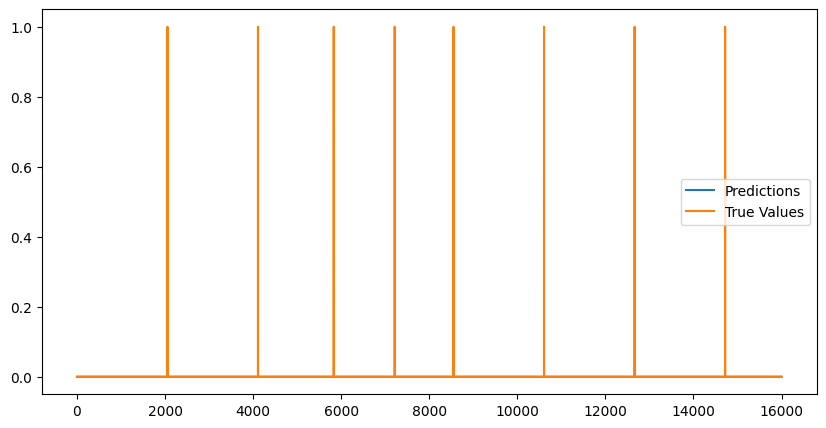


 Recall: 0.0 
 


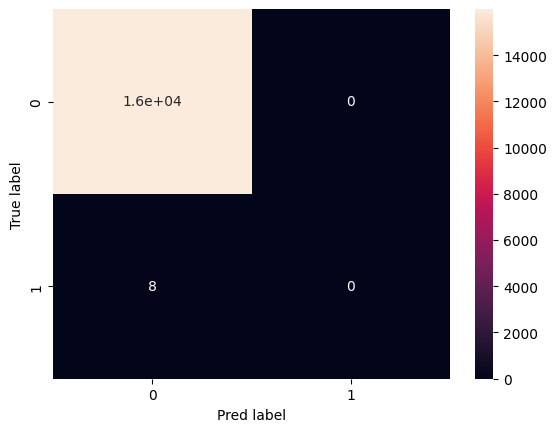

In [ ]:
# Train data analysis
y_pred = model1.predict(X_train).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_train)


125/125 [==============================] - 0s 3ms/step

 Log loss : 0.0080 
 


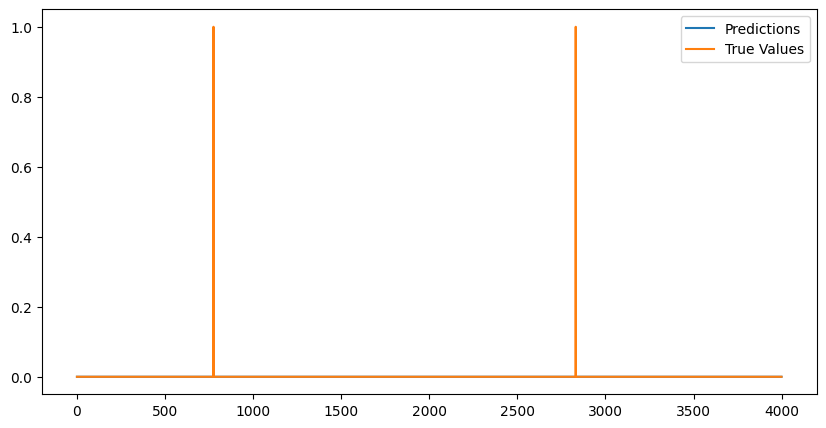


 Recall: 0.0 
 


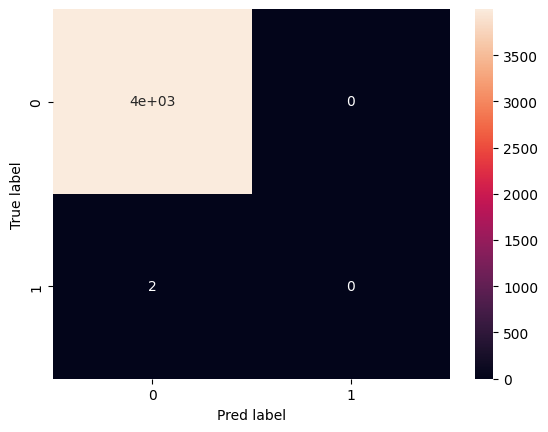

In [ ]:
# Val set analysis

y_pred = model1.predict(X_val).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_val)

157/157 [==============================] - 1s 4ms/step

 Log loss : 0.0096 
 


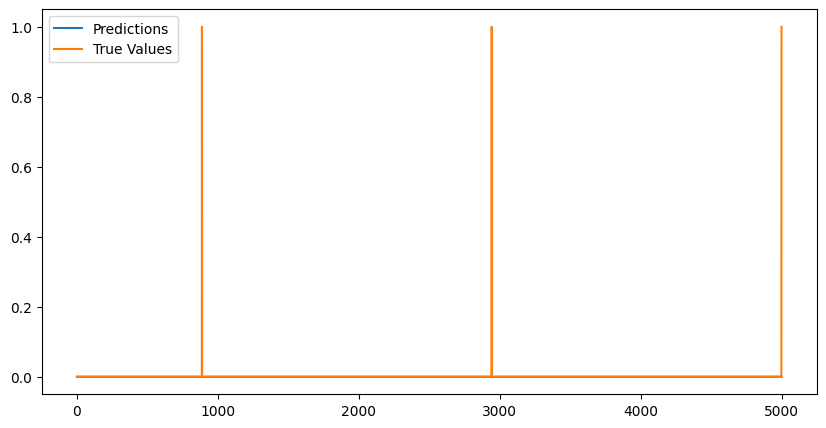


 Recall: 0.0 
 


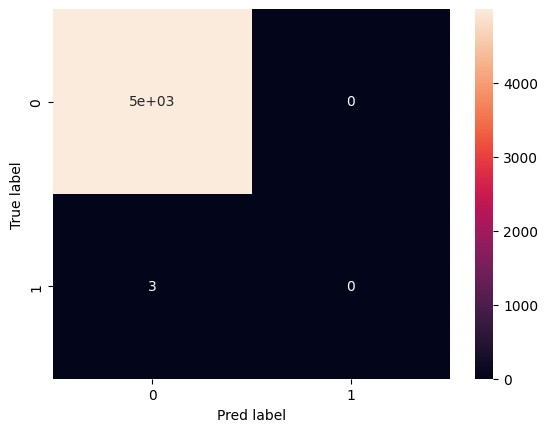

In [ ]:
# Test set analysis

y_pred = model1.predict(X_test).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_test)


### CNN

In [ ]:
model2 = Sequential()
model2.add(InputLayer((100, 15)))
model2.add(Conv1D(16, kernel_size=3))
model2.add(Flatten())
model2.add(Dense(16, 'relu'))
model2.add(Dense(1, 'sigmoid'))

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 16)            736       
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                25104     
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=BinaryCrossentropy(),
              optimizer = Adam(learning_rate=0.02),
              metrics=[Recall()])

In [ ]:
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp2])

Epoch 1/20
495/500 [============================>.] - ETA: 0s - loss: 127.1359 - recall_2: 0.0000e+00

500/500 [==============================] - 10s 6ms/step - loss: 125.8651 - recall_2: 0.0000e+00 - val_loss: 0.0522 - val_recall_2: 0.0000e+00
Epoch 2/20
486/500 [============================>.] - ETA: 0s - loss: 0.0209 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 5ms/step - loss: 0.0205 - recall_2: 0.0000e+00 - val_loss: 0.0103 - val_recall_2: 0.0000e+00
Epoch 3/20
487/500 [============================>.] - ETA: 0s - loss: 0.0077 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 5ms/step - loss: 0.0080 - recall_2: 0.0000e+00 - val_loss: 0.0064 - val_recall_2: 0.0000e+00
Epoch 4/20
499/500 [============================>.] - ETA: 0s - loss: 0.0058 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 6ms/step - loss: 0.0058 - recall_2: 0.0000e+00 - val_loss: 0.0053 - val_recall_2: 0.0000e+00
Epoch 5/20
489/500 [============================>.] - ETA: 0s - loss: 0.0047 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 6ms/step - loss: 0.0050 - recall_2: 0.0000e+00 - val_loss: 0.0047 - val_recall_2: 0.0000e+00
Epoch 6/20
488/500 [============================>.] - ETA: 0s - loss: 0.0047 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 6ms/step - loss: 0.0046 - recall_2: 0.0000e+00 - val_loss: 0.0045 - val_recall_2: 0.0000e+00
Epoch 7/20
490/500 [============================>.] - ETA: 0s - loss: 0.0045 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 5ms/step - loss: 0.0045 - recall_2: 0.0000e+00 - val_loss: 0.0044 - val_recall_2: 0.0000e+00
Epoch 8/20
495/500 [============================>.] - ETA: 0s - loss: 0.0044 - recall_2: 0.0000e+00

500/500 [==============================] - 5s 9ms/step - loss: 0.0044 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 9/20
499/500 [============================>.] - ETA: 0s - loss: 0.0043 - recall_2: 0.0000e+00

500/500 [==============================] - 4s 8ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 10/20
493/500 [============================>.] - ETA: 0s - loss: 0.0044 - recall_2: 0.0000e+00

500/500 [==============================] - 4s 8ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 11/20
498/500 [============================>.] - ETA: 0s - loss: 0.0043 - recall_2: 0.0000e+00

500/500 [==============================] - 4s 7ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 12/20
489/500 [============================>.] - ETA: 0s - loss: 0.0044 - recall_2: 0.0000e+00

500/500 [==============================] - 3s 6ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 13/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 14/20
500/500 [==============================] - 2s 4ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 15/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 16/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 17/20
500/500 [==============================] - 3s 7ms/step - loss: 0.0043 - recall_2: 0.0000e+00 - val_loss: 0.0043 - val_recall_2: 0.0000e+00
Epoch 18/20
500/500 [==============================] - 3s 6ms/step - loss: 0.0043 - recall_2: 0.0000e+00 -

#### Inference

In [ ]:
model2 = load_model('model1/')

500/500 [==============================] - 2s 4ms/step

 Log loss : 0.0080 
 


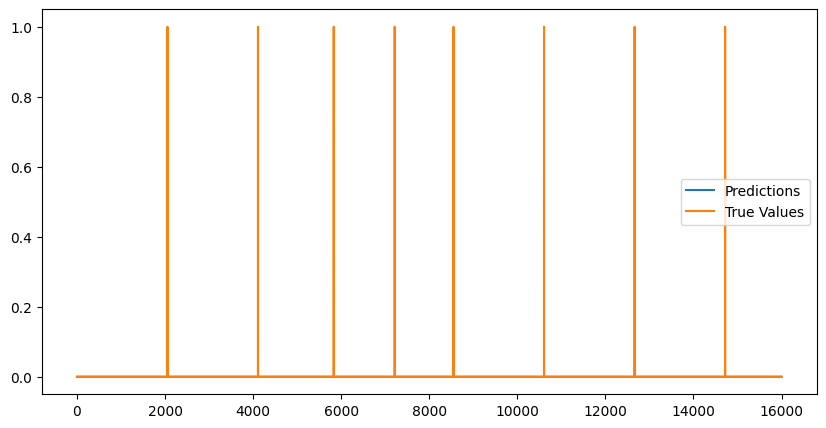


 Recall: 0.0 
 


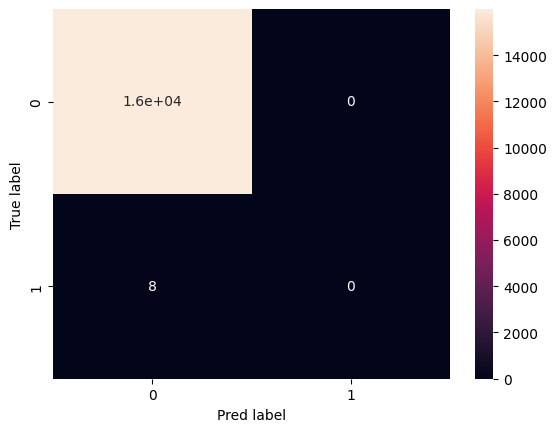

In [ ]:
# Train data analysis
y_pred = model1.predict(X_train).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_train)


125/125 [==============================] - 0s 3ms/step

 Log loss : 0.0080 
 


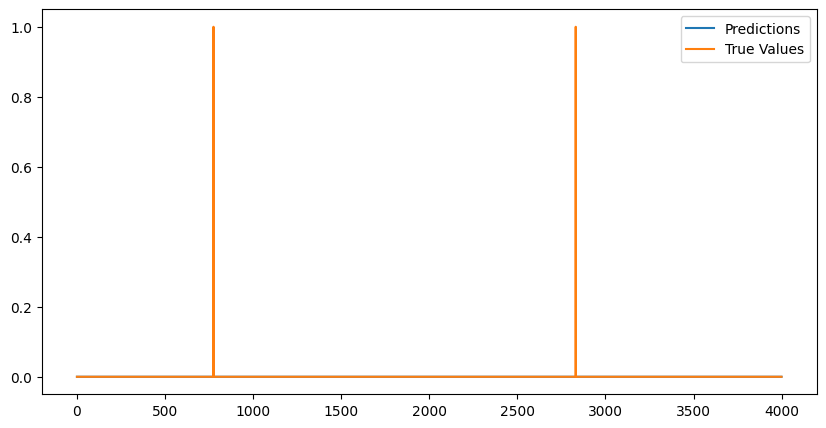


 Recall: 0.0 
 


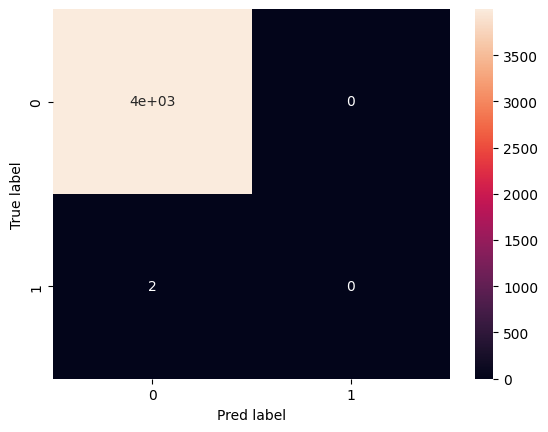

In [ ]:
# Val set analysis

y_pred = model1.predict(X_val).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_val)

157/157 [==============================] - 1s 3ms/step

 Log loss : 0.0096 
 


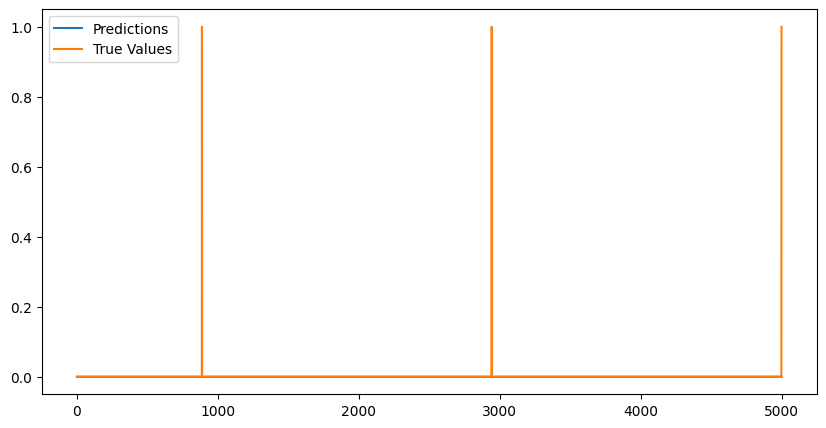


 Recall: 0.0 
 


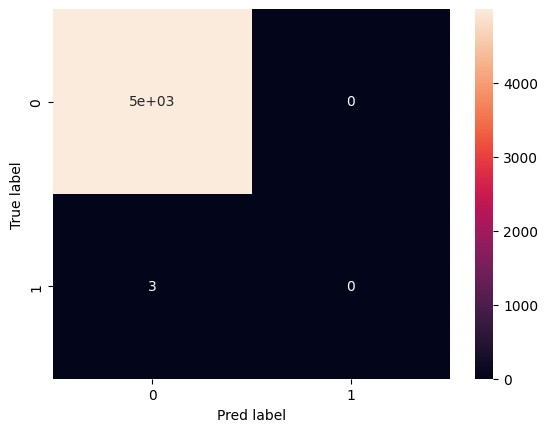

In [ ]:
# Test set analysis

y_pred = model1.predict(X_test).flatten()
y_pred = np.rint(y_pred)
plot_pred_vs_true(y_pred,y_test)


# Conclusion

1. For the naive approach, LSTM and CNN performed better than XGB and RandomForest
2. For the Advanced approach , the deep learning methods clearly overfitted the data and gave bad results, where as the Random forest gave 2/3 times forcasted the fault both in validation and test set